In [1]:
# load environment variables
from dotenv import load_dotenv
import os
load_dotenv()

True

# MLflow setup

In [2]:
import os
import mlflow

MLFLOW_USERNAME = os.getenv('MLFLOW_TRACKING_USERNAME')
MLFLOW_PASSWORD = os.getenv('MLFLOW_TRACKING_PASSWORD')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Adult")
mlflow.start_run(run_name="EDA")

<ActiveRun: >

# Data Loading

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

# Data Combination

In [4]:
import pandas as pd

# Combine features and target into one DataFrame
df = pd.concat([X, y], axis=1)
print("Data sample after combining X and y:")
df


Data sample after combining X and y:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [5]:
target_column = y.columns[0]

# Create a Dataset object from the DataFrame
dataset = mlflow.data.from_pandas(df, name="UCI Adult Income", targets=target_column)

mlflow.log_input(dataset, context="dataset")

/Users/tharindu/git/mlflow_iris_example/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [6]:
import json

# Define the directory name
metadata_dir = "metadata"

# Create the directory if it doesn't exist
os.makedirs(metadata_dir, exist_ok=True)

metadata_file_path = os.path.join(metadata_dir, "adult_metadata.json")
with open(metadata_file_path, "w") as f:
    json.dump(adult.metadata, f, indent=2)


unique_values = {}
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_values[col] = df[col].dropna().unique().tolist()


unique_values_file_path = os.path.join(metadata_dir, "unique_values.json")
with open(unique_values_file_path, "w") as f:
    json.dump(unique_values, f, indent=2)


In [7]:
mlflow.log_artifact(unique_values_file_path, artifact_path="metadata")
mlflow.log_artifact(metadata_file_path, artifact_path="metadata")

# Initial Data Inspection

In [8]:
# Check the dimensions and basic info
print("Dataset shape:", df.shape)
df.info()
print(df.describe())

# For categorical columns, you can view unique values as well
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"Unique values for {col}: {df[col].unique()}")


Dataset shape: (48842, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
                age        fnlwgt  education-num  capital-gain  ca

### 🔍 Problem:
```
['<=50K', '>50K', '<=50K.', '>50K.']
```

This means the **same labels** appear with and without a **trailing period (`.`)**.

---

### 📌 Cause:
The UCI Adult dataset comes in two files:
- **`adult.data`** (no headers, training data)
- **`adult.test`** (starts with a header/comment line, test data)

In the `adult.test` file, **labels have a period** at the end — i.e., `'>50K.'` and '`<=50K.'`.

---

### ⚠️ Why It Matters:
- Your model might treat `'<=50K'` and '`<=50K.'` as **different classes**, which leads to:
  - Incorrect label counts
  - Misleading model evaluation
  - Skewed visualizations

---

### ✅ Solution:
Standardize the labels early during preprocessing:

In [9]:
# Strip whitespace and trailing periods from income
df['income'] = df['income'].str.strip().str.replace('.', '', regex=False)


# Handling Missing Values

In [10]:
import numpy as np

# Replace '?' with np.nan for consistent missing value notation
df.replace('?', np.nan, inplace=True)

# Check the number of missing values per column
print("Missing values count:")
print(df.isnull().sum())

# Calculate percentage of missing values (optional)
missing_percent = df.isnull().mean() * 100
print("Missing values percentage per column:")
print(missing_percent)


Missing values count:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64
Missing values percentage per column:
age               0.000000
workclass         5.730724
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        5.751198
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    1.754637
income            0.000000
dtype: float64


In [11]:
for col in categorical_cols:
    df[col].fillna('Unknown', inplace=True)

/var/folders/_j/56hv4rgj2yn_2z_m3dwvcwhc0000gn/T/ipykernel_62740/2383048195.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)


## Display and log dataset metadata

In [12]:
# Log basic info
mlflow.log_params({
    "dataset_name": "adult",
    "no_of_cols": df.shape[1],
    "no_of_rows": df.shape[0],
    "columns": ','.join(df.columns.tolist()),
    "numerical_columns_count": df.select_dtypes(include='number').shape[1],
    "missing_values_total": int(df.isnull().sum().sum()),
    "target_column": "income",
    "categorical_columns_count": len(categorical_cols),
    "categorical_columns": ','.join(categorical_cols),
    "numerical_columns": ','.join(df.select_dtypes(include='number').columns.tolist()),
    "target_column_unique_values": df['income'].nunique(),
    "target_column_unique_values_list": ','.join(df['income'].unique().tolist()),
    "target_column_value_counts": df['income'].value_counts().to_dict(),
    "target_column_value_counts_percentage": df['income'].value_counts(normalize=True).to_dict()
})


# Exploratory Data Analysis (EDA)
## EDA for Numerical Features

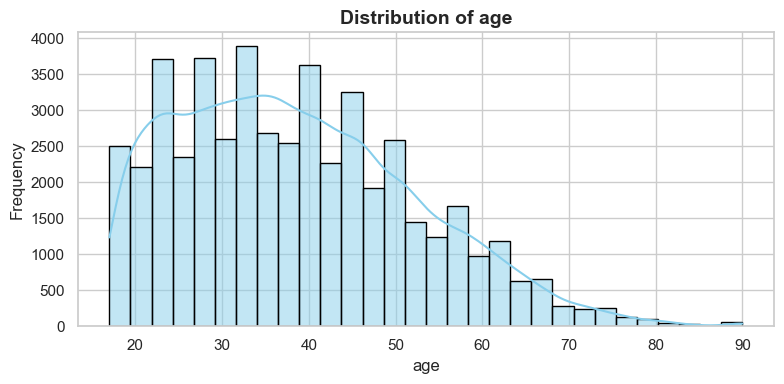

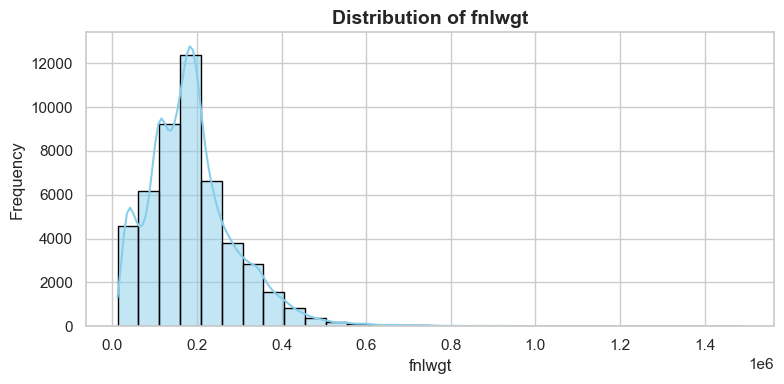

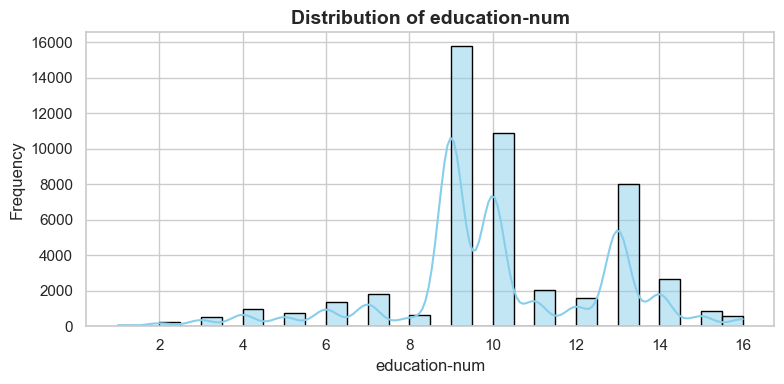

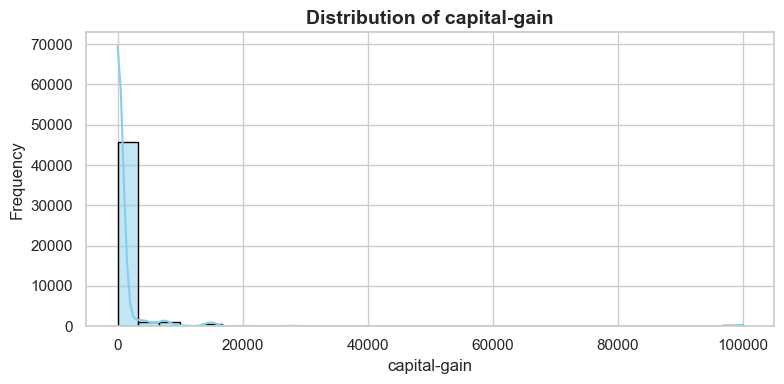

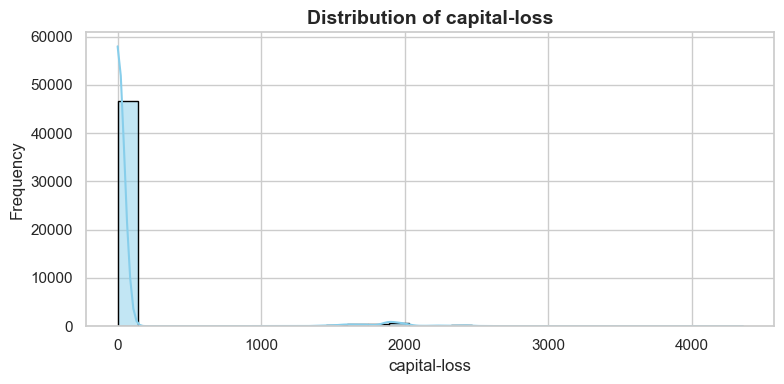

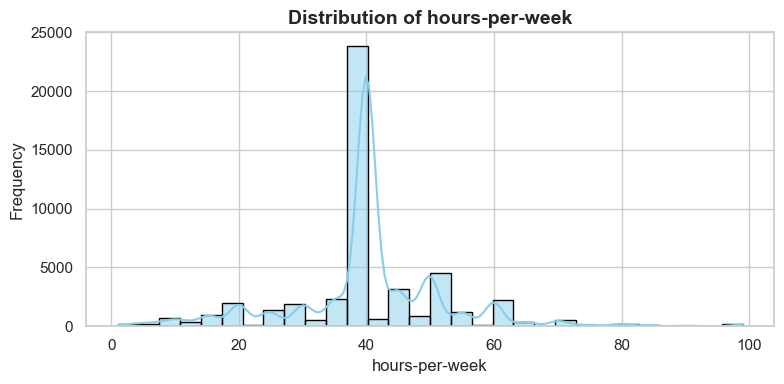

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

sns.set(style="whitegrid")

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}", fontsize=14, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()

    # Log the figure directly to MLflow
    artifact_path = f"numerical_distributions_histograms/hist_{col}.png"
    mlflow.log_figure(plt.gcf(), artifact_path)

    plt.show()
    plt.close()

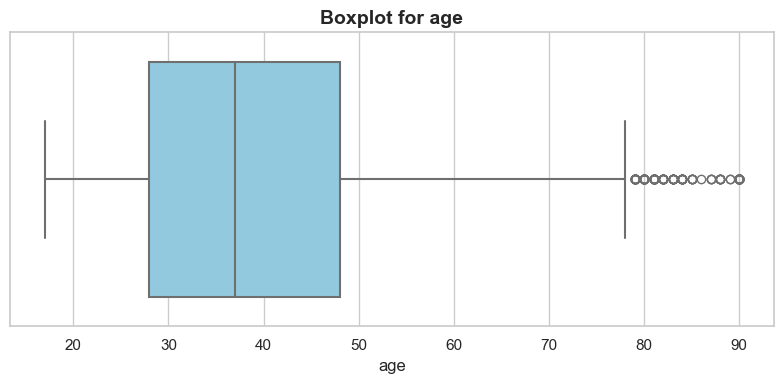

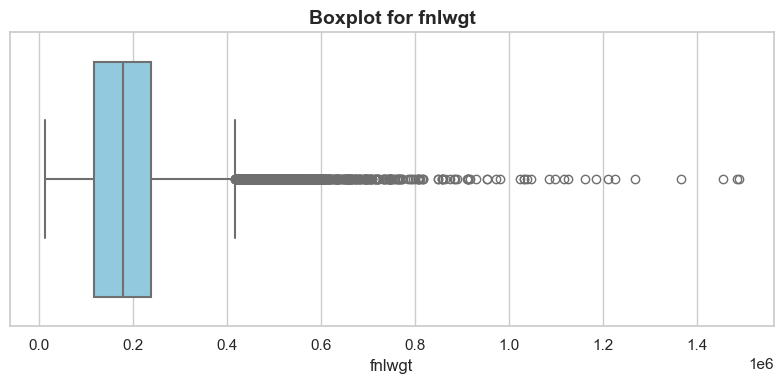

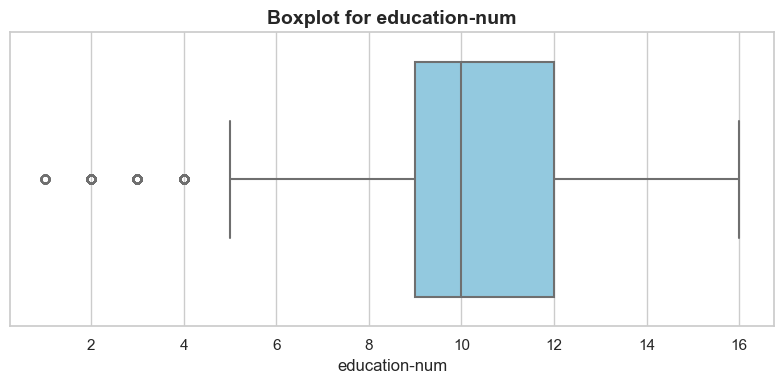

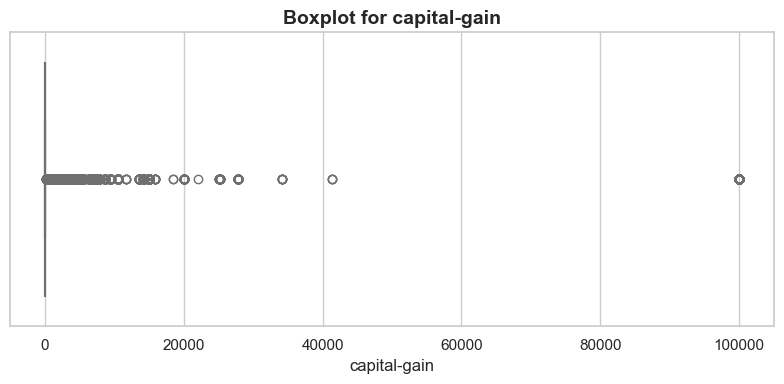

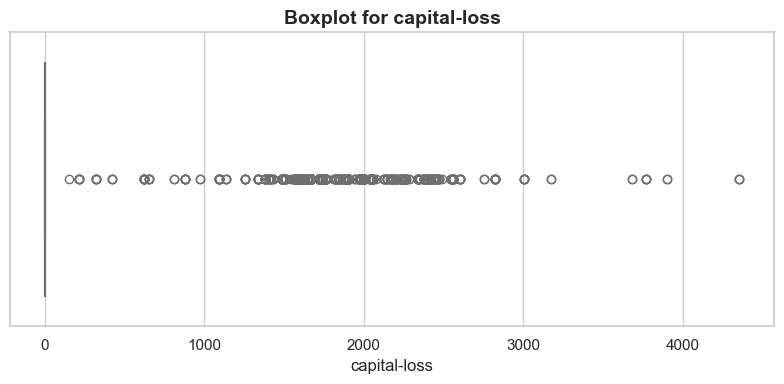

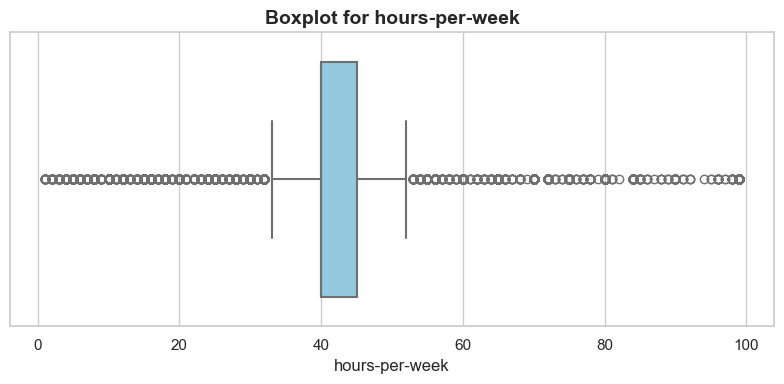

In [14]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], color='skyblue', linewidth=1.5)
    plt.title(f"Boxplot for {col}", fontsize=14, fontweight='bold')
    plt.xlabel(col)
    plt.tight_layout()

    # Log the figure directly to MLflow
    artifact_path = f"numerical_distributions_boxplots/boxplot_{col}.png"
    mlflow.log_figure(plt.gcf(), artifact_path)

    plt.show()
    plt.close()

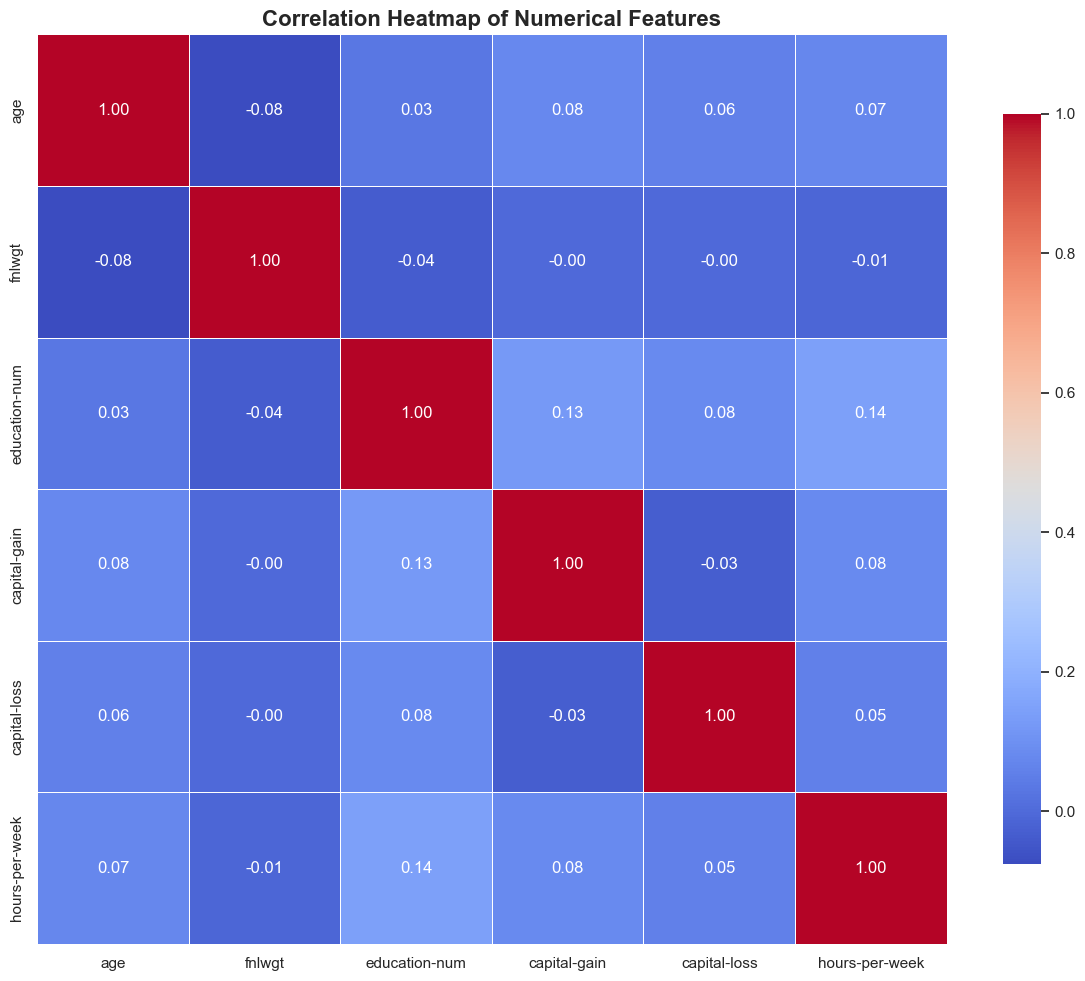

In [15]:
plt.figure(figsize=(12, 10))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
    square=True, cbar_kws={"shrink": .8}
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()

# Log the figure directly to MLflow
mlflow.log_figure(plt.gcf(), "correlation_heatmap.png")

plt.show()
plt.close()

# EDA for Categorical Features

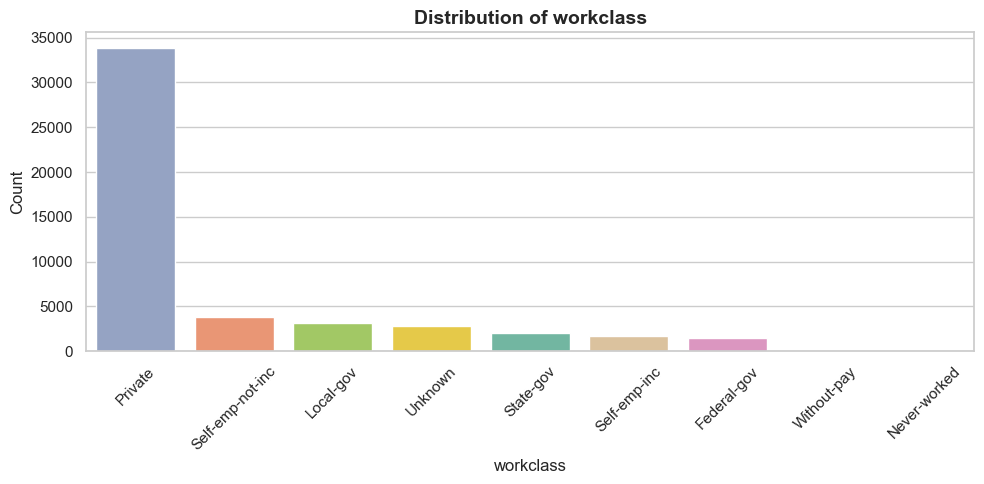

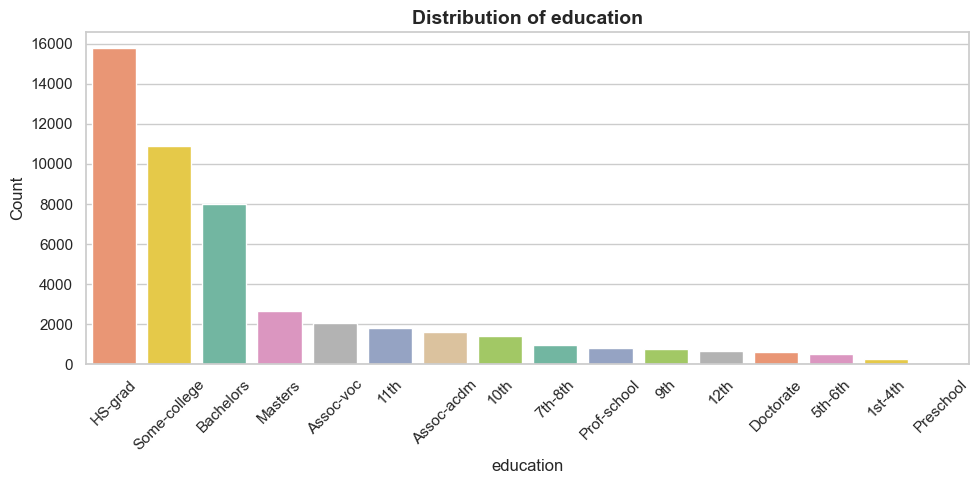

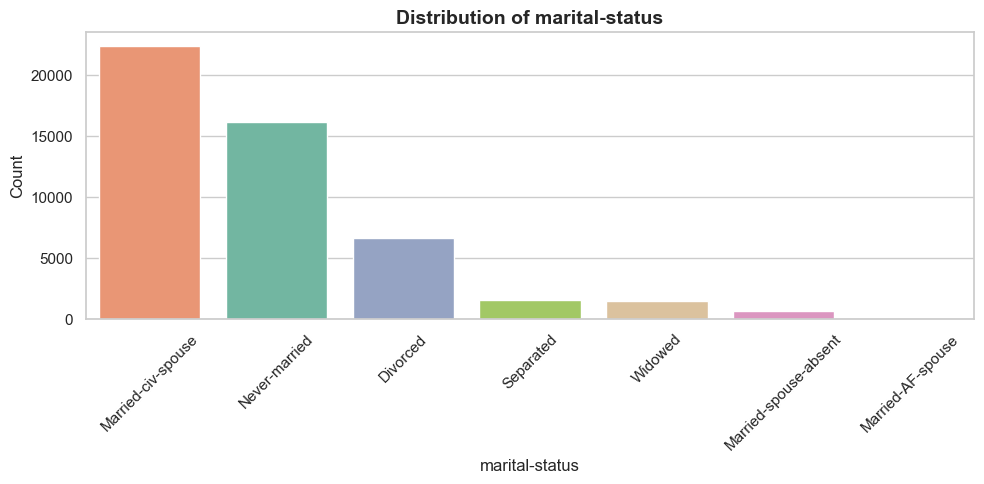

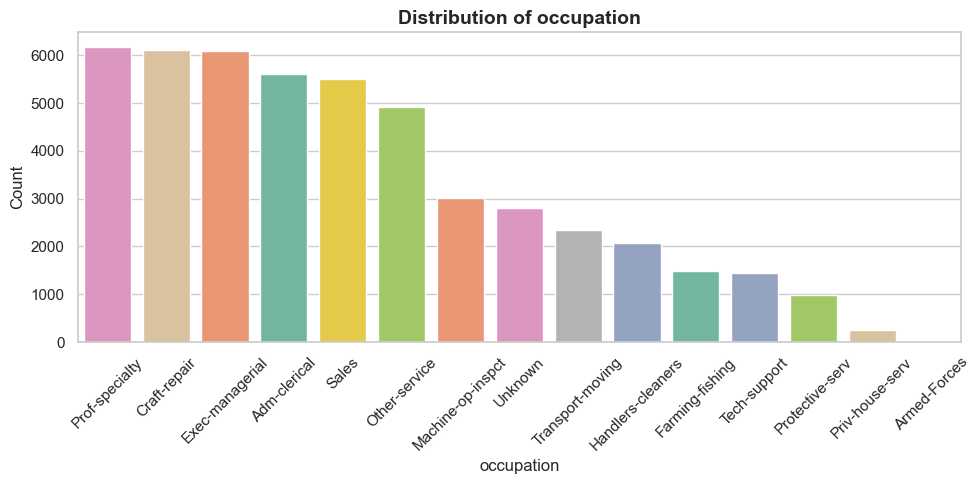

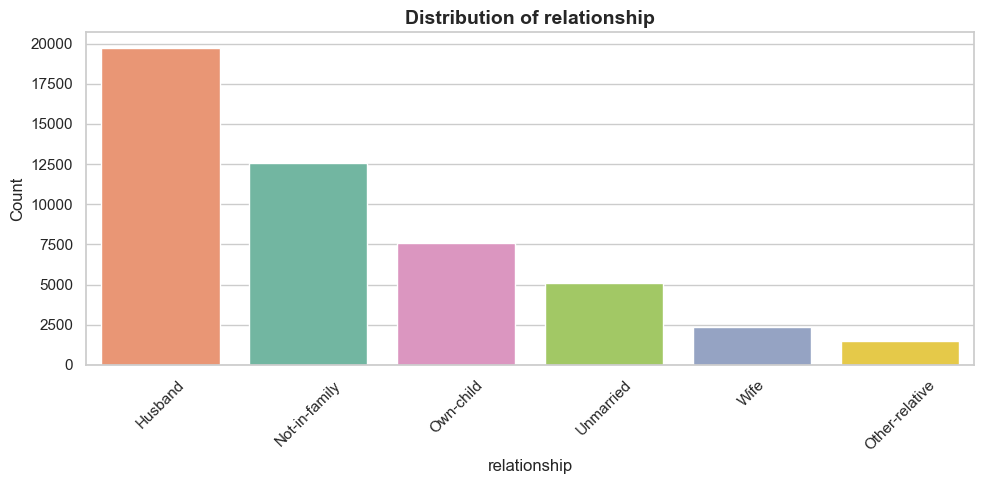

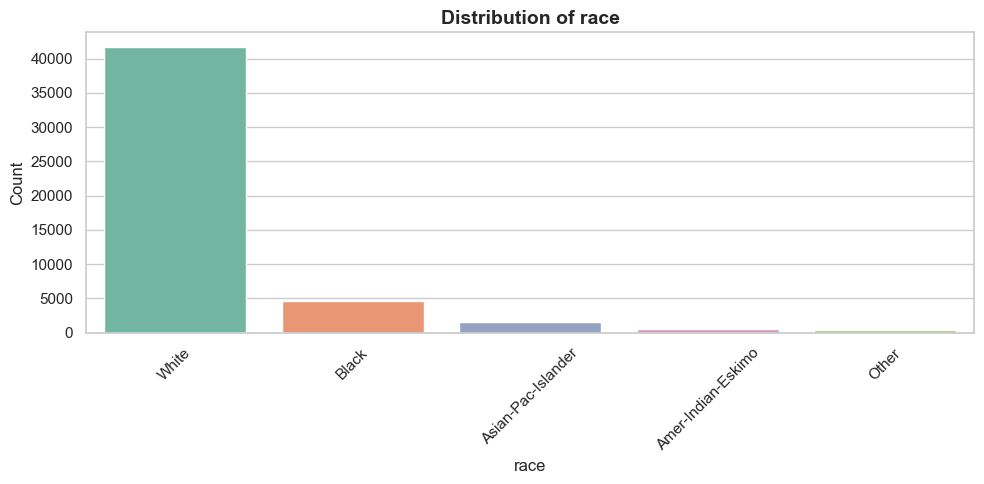

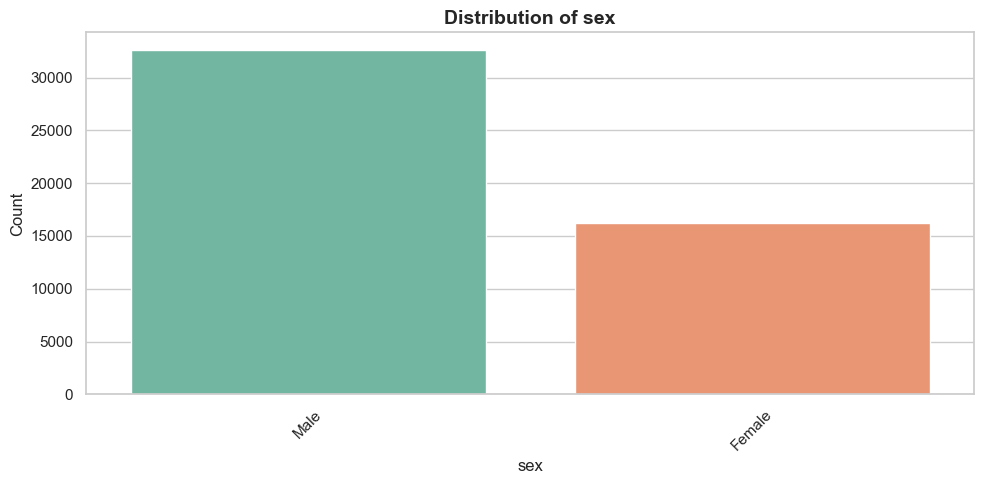

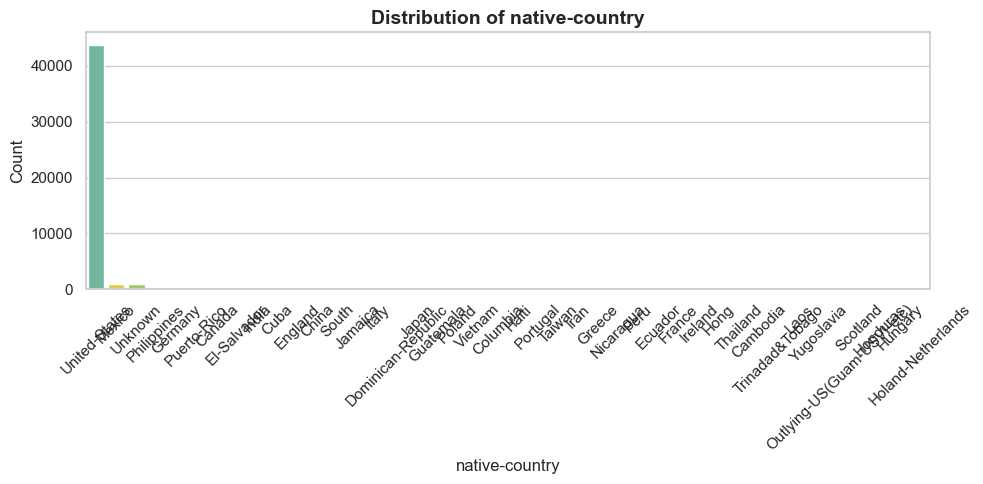

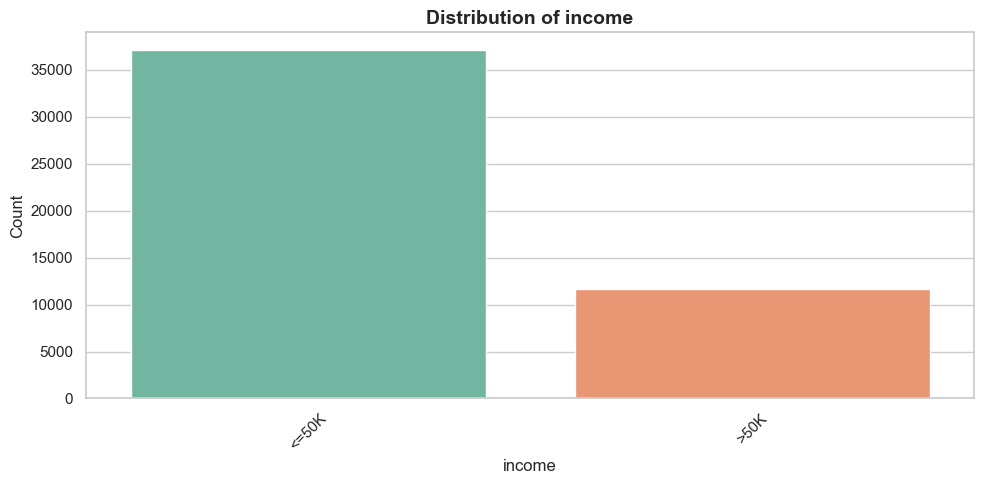

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

sns.set(style="whitegrid")

# Plot and log each categorical feature
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(
        data=df,
        x=col,
        hue=col,
        order=df[col].value_counts().index,
        palette="Set2",
        legend=False
    )
    plt.title(f"Distribution of {col}", fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Log the figure directly to MLflow
    artifact_path = f"categorical_distributions/categorical_dist_{col}.png"
    mlflow.log_figure(plt.gcf(), artifact_path)

    plt.show()
    plt.close()

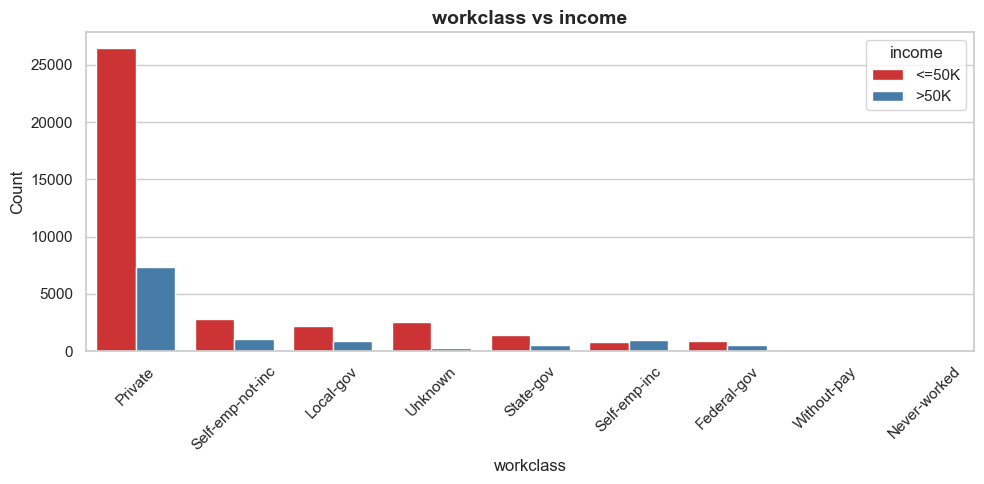

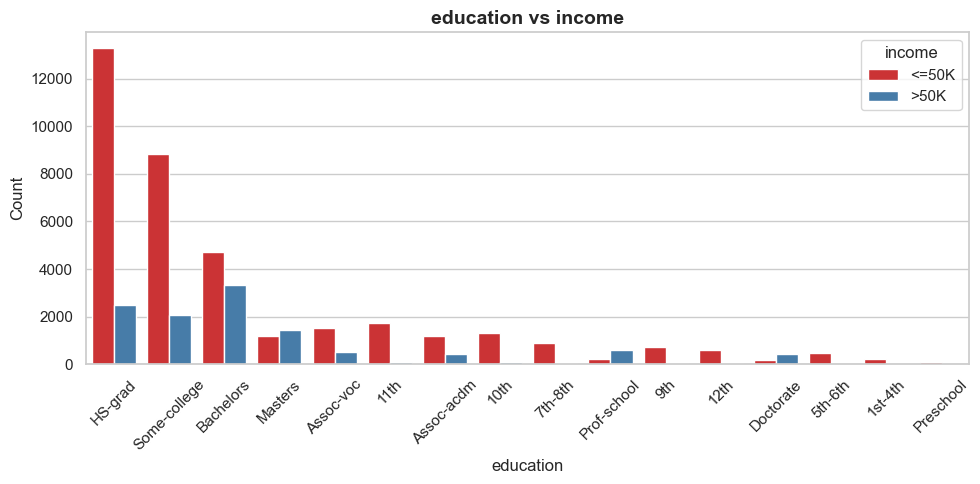

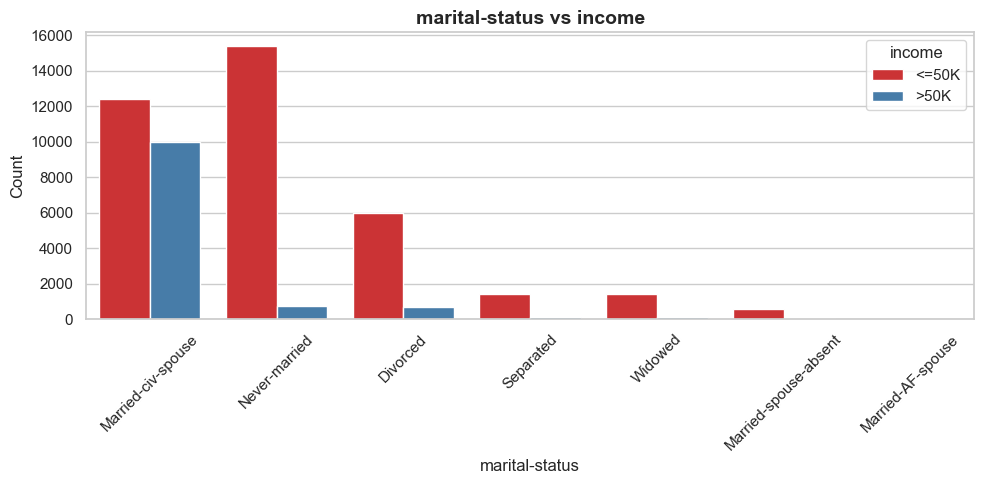

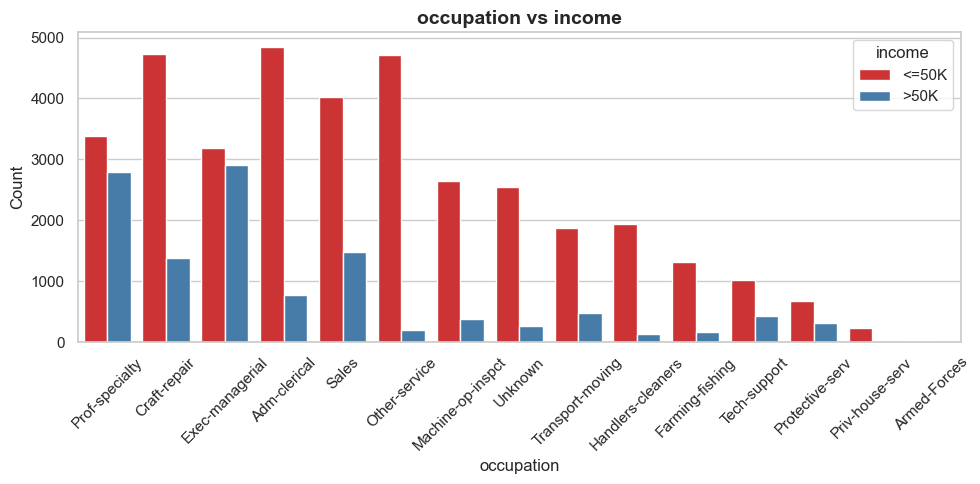

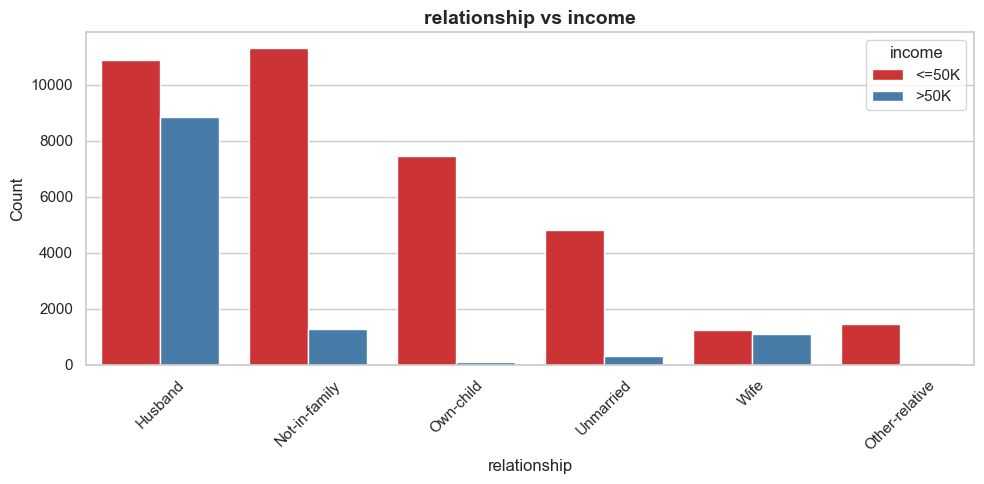

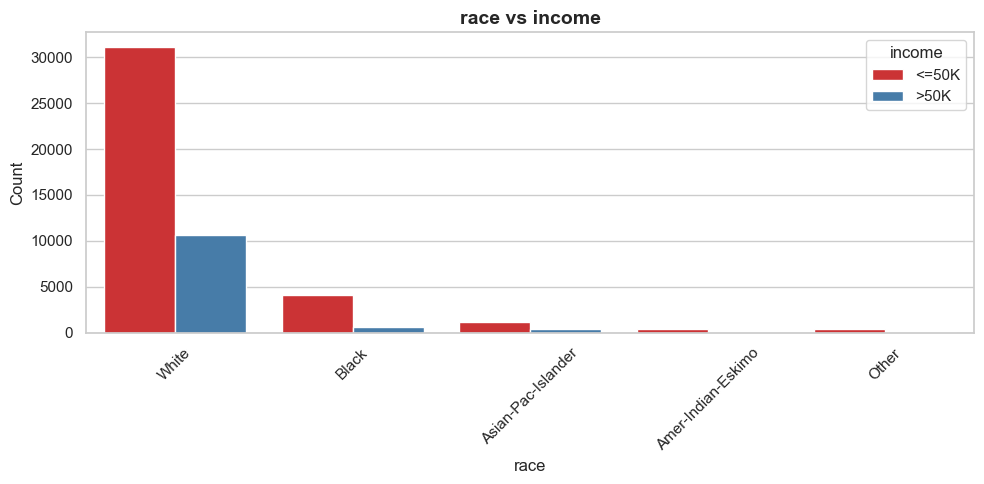

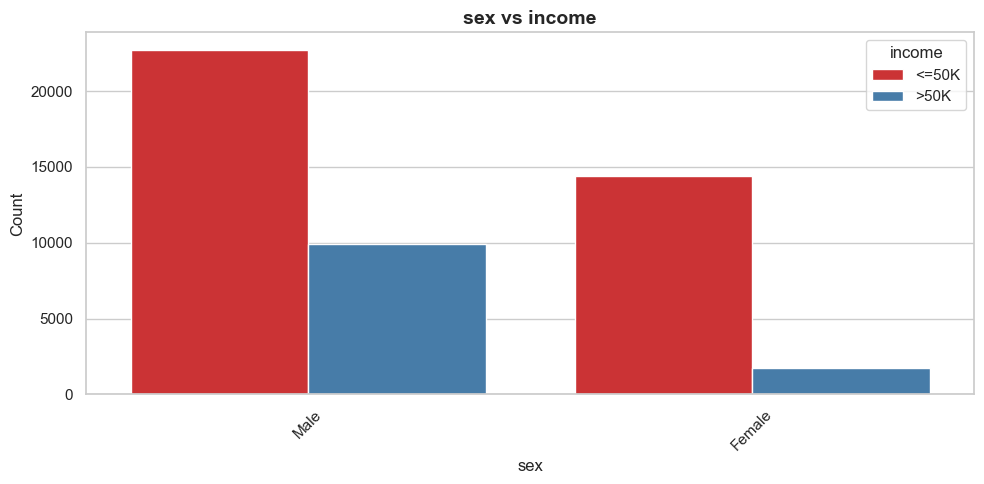

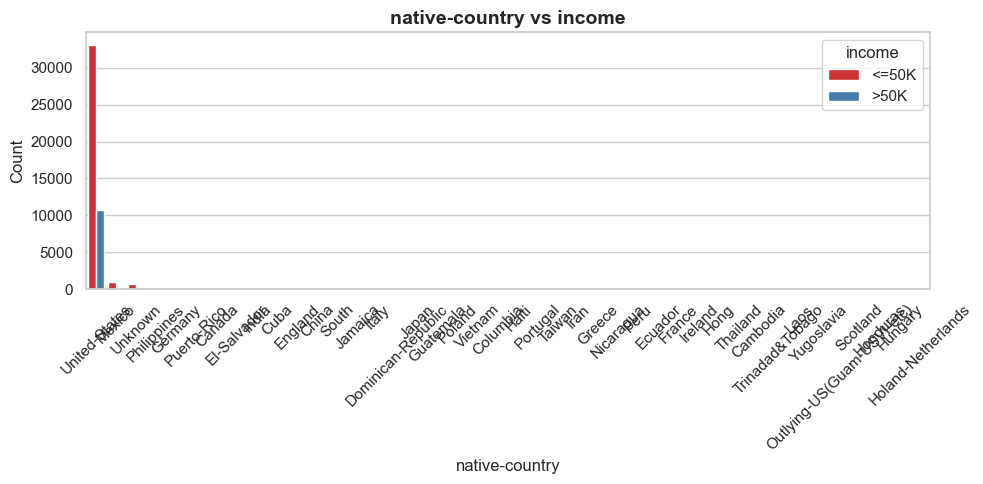

/var/folders/_j/56hv4rgj2yn_2z_m3dwvcwhc0000gn/T/ipykernel_62740/1032425529.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, loc='upper right')


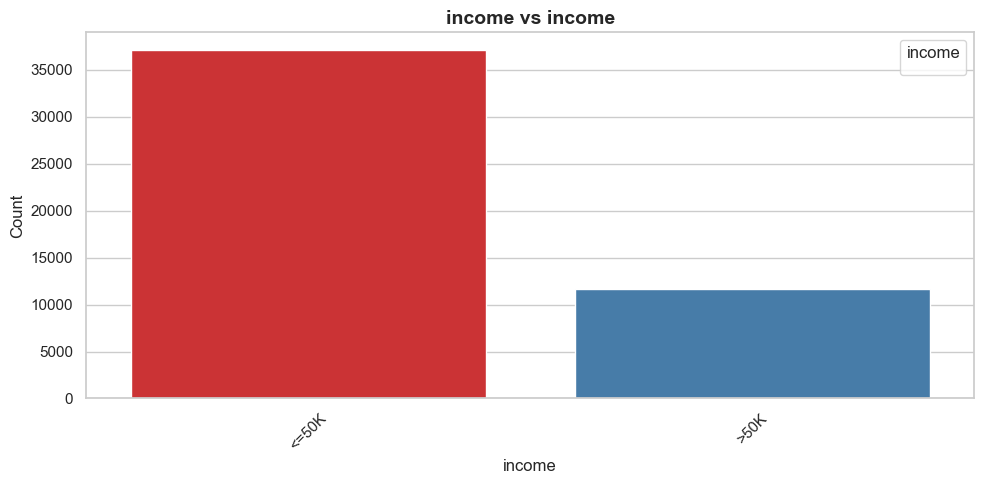

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

sns.set(style="whitegrid")

target_col = 'income'

if target_col in df.columns:
    for col in categorical_cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(
            data=df,
            x=col,
            hue=target_col,
            order=df[col].value_counts().index,
            palette="Set1"
        )
        plt.title(f"{col} vs {target_col}", fontsize=14, fontweight='bold')
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title=target_col, loc='upper right')
        plt.tight_layout()

        # Log the figure directly to MLflow
        artifact_path = f"categorical_vs_target/{col}_vs_{target_col}.png"
        mlflow.log_figure(plt.gcf(), artifact_path)

        plt.show()
        plt.close()

# Data Transformation & Encoding

## Categorical Encoding

In [ ]:
# One-Hot Encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)
print("Data shape after encoding:", df_encoded.shape)


Data shape after encoding: (48842, 101)


In [ ]:
df_encoded

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Unknown,native-country_Vietnam,native-country_Yugoslavia,income_>50K
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,38,215646,9,0,0,40,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,53,234721,7,0,0,40,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,28,338409,13,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,13,0,0,36,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
48838,64,321403,9,0,0,40,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
48839,38,374983,13,0,0,50,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
48840,44,83891,13,5455,0,40,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False


In [ ]:
df_encoded.dtypes

age                             float64
fnlwgt                          float64
education-num                   float64
capital-gain                    float64
capital-loss                    float64
                                 ...   
native-country_United-States       bool
native-country_Unknown             bool
native-country_Vietnam             bool
native-country_Yugoslavia          bool
income_>50K                        bool
Length: 101, dtype: object

## Feature Scaling (Optional)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Apply scaling only to numerical columns (ensure column names match your post-encoding setup)
scaled_numerical = scaler.fit_transform(df_encoded[numerical_cols])
df_encoded[numerical_cols] = scaled_numerical


In [ ]:
df_encoded

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Unknown,native-country_Vietnam,native-country_Yugoslavia,income_>50K
0,0.025996,-1.061979,1.136512,0.146932,-0.217127,-0.034087,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.828308,-1.007104,1.136512,-0.144804,-0.217127,-2.213032,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,-0.046942,0.246034,-0.419335,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,1.047121,0.426663,-1.197259,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,-0.776316,1.408530,1.136512,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.025996,0.243884,1.136512,-0.144804,-0.217127,-0.356894,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
48838,1.849433,1.247492,-0.419335,-0.144804,-0.217127,-0.034087,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
48839,-0.046942,1.754865,1.136512,-0.144804,-0.217127,0.772930,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
48840,0.390683,-1.001612,1.136512,0.587220,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False


# Splitting Data for Model Training

In [ ]:
from sklearn.model_selection import train_test_split

# First, ensure the target variable has a clear name. Here we assume 'income' is the target.
# Adjust this to the actual target column name in your dataset.
target_col = 'income_>50K'
X_final = df_encoded.drop(columns=[target_col])
y_final = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (39073, 100)
Testing set shape: (9769, 100)


In [ ]:
X_final

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Unknown,native-country_Vietnam,native-country_Yugoslavia
0,0.025996,-1.061979,1.136512,0.146932,-0.217127,-0.034087,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,0.828308,-1.007104,1.136512,-0.144804,-0.217127,-2.213032,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,-0.046942,0.246034,-0.419335,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,1.047121,0.426663,-1.197259,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
4,-0.776316,1.408530,1.136512,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.025996,0.243884,1.136512,-0.144804,-0.217127,-0.356894,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
48838,1.849433,1.247492,-0.419335,-0.144804,-0.217127,-0.034087,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
48839,-0.046942,1.754865,1.136512,-0.144804,-0.217127,0.772930,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
48840,0.390683,-1.001612,1.136512,0.587220,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
mlflow.set_experiment("CaliforniaHousing")
mlflow.start_run(run_name="Preprocessing")

<ActiveRun: >

In [ ]:
from sklearn.model_selection import train_test_split

X = df.copy()
X.drop(columns=["MedHouseVal"], inplace=True)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlflow.log_param("train_rows", X_train.shape[0])
mlflow.log_param("test_rows", X_test.shape[0])
mlflow.log_param("test_split", 0.2)

0.2

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlflow.log_param("scaler", "StandardScaler")

'StandardScaler'

In [ ]:
import joblib

# Save scaled arrays & y
np.save(os.path.join(OUTPUT_DIR, "X_train_scaled.npy"), X_train_scaled)
np.save(os.path.join(OUTPUT_DIR, "X_test_scaled.npy"), X_test_scaled)
np.save(os.path.join(OUTPUT_DIR, "y_train.npy"), y_train)
np.save(os.path.join(OUTPUT_DIR, "y_test.npy"), y_test)

# Save scaler for inference
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "scaler.pkl"))

# Log artifacts
mlflow.log_artifact(os.path.join(OUTPUT_DIR, "X_train_scaled.npy"), artifact_path="data_prepared")
mlflow.log_artifact(os.path.join(OUTPUT_DIR, "X_test_scaled.npy"), artifact_path="data_prepared")
mlflow.log_artifact(os.path.join(OUTPUT_DIR, "y_train.npy"), artifact_path="data_prepared")
mlflow.log_artifact(os.path.join(OUTPUT_DIR, "y_test.npy"), artifact_path="data_prepared")
mlflow.log_artifact(os.path.join(OUTPUT_DIR, "scaler.pkl"), artifact_path="data_prepared")

In [ ]:
import pandas as pd
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Use a small example (e.g., first 5 rows)
input_example = pd.DataFrame(X_train[:5], columns=X_train.columns)
signature = infer_signature(X_train, X_train_scaled)

mlflow.sklearn.log_model(
    scaler,
    artifact_path="scaler_model_v2",
    input_example=input_example,
    signature=signature
)

2025/04/14 20:26:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/14 20:26:55 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "MedInc",
      "HouseAge",
      "AveRooms",
      "AveBedrms",
      "Population",
      "AveOccup",
      "Latitude",
      "Longitude",
      "PopDensity"
    ],
    "data": [
      [
        3.2596,
        33.0,
        5.017656500802568,
        1.0064205457463884,
        2300.0,
        3.691813804173355,
        32.71,
        -117.03,
        623.0
      ],
      [
        3.8125,
        49.0,
        4.473544973544974,
        1.041005291005291,
        1314.0,
        1.7380952380952381,
        33.77,
        -118.16,
        756.0
      ],
      [
        4.1563,
        4.0,
        5.645833333333333,
        0.9851190476190477,
        915.0,
        2.7232142857142856,
        34.66,
        -120.48,
        336.0
  

In [ ]:
mlflow.end_run()

🏃 View run Preprocessing at: http://135.235.186.123/#/experiments/4/runs/094a4666ad9c449fa51355917cdb237b
🧪 View experiment at: http://135.235.186.123/#/experiments/4


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow.sklearn
import numpy as np

def evaluate_and_log(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Log metrics
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2_Score", r2)

    print(f"📊 {model_name} Evaluation:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

In [ ]:
X_train_scaled.shape

(16512, 9)

In [ ]:
from sklearn.linear_model import LinearRegression

mlflow.set_experiment("CaliforniaHousing")
with mlflow.start_run(run_name="LinearRegression", tags={"mlflow.system_metrics_enabled": "true"}):
    model = LinearRegression()
    mlflow.log_param("fit_intercept", model.fit_intercept)

    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    evaluate_and_log("Linear Regression", y_test, preds)

    input_example = pd.DataFrame(X_train_scaled[:5], columns=X_train.columns)
    signature = infer_signature(X_train_scaled, model.predict(X_train_scaled))

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

📊 Linear Regression Evaluation:
MAE: 0.5111
MSE: 0.5055
RMSE: 0.7110
R²: 0.6143
🏃 View run LinearRegression at: http://135.235.186.123/#/experiments/4/runs/2b65cac878fc4cfaaf8504abe8a845f5
🧪 View experiment at: http://135.235.186.123/#/experiments/4


In [ ]:
from sklearn.ensemble import RandomForestRegressor

mlflow.set_experiment("CaliforniaHousing")
with mlflow.start_run(run_name="RandomForestRegressor"):
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

    # Log hyperparameters
    mlflow.log_params({
        "n_estimators": 100,
        "max_depth": 10,
        "random_state": 42
    })

    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    evaluate_and_log("Random Forest Regressor", y_test, preds)

    input_example = pd.DataFrame(X_train_scaled[:5], columns=X_train.columns)
    signature = infer_signature(X_train_scaled, model.predict(X_train_scaled))

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

📊 Random Forest Regressor Evaluation:
MAE: 0.3672
MSE: 0.2968
RMSE: 0.5448
R²: 0.7735
🏃 View run RandomForestRegressor at: http://135.235.186.123/#/experiments/4/runs/6260816ddcdc4b68b5b35c864f524b1e
🧪 View experiment at: http://135.235.186.123/#/experiments/4


In [ ]:
from sklearn.svm import SVR

mlflow.set_experiment("CaliforniaHousing")
with mlflow.start_run(run_name="Support Vector Regressor"):
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

    # Log hyperparameters
    mlflow.log_params({
        "kernel": 'rbf',
        "C": 1.0,
        "epsilon": 0.1,
        "random_state": 42
    })

    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    evaluate_and_log("Support Vector Regressor ", y_test, preds)

    input_example = pd.DataFrame(X_train_scaled[:5], columns=X_train.columns)
    signature = infer_signature(X_train_scaled, model.predict(X_train_scaled))

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

📊 Support Vector Regressor  Evaluation:
MAE: 0.3847
MSE: 0.3302
RMSE: 0.5746
R²: 0.7480
🏃 View run Support Vector Regressor at: http://135.235.186.123/#/experiments/4/runs/e70ab9e57faa4106955180c4faac110f
🧪 View experiment at: http://135.235.186.123/#/experiments/4


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


mlflow.set_experiment("CaliforniaHousing")
with mlflow.start_run(run_name="GradientBoostingRegressor"):
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

    # Log hyperparameters
    mlflow.log_params({
        "n_estimators": 100,
        "learning_rate": 0.1,
        "max_depth": 3
    })

    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    evaluate_and_log("GradientBoostingRegressor ", y_test, preds)

    input_example = pd.DataFrame(X_train_scaled[:5], columns=X_train.columns)
    signature = infer_signature(X_train_scaled, model.predict(X_train_scaled))

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

📊 GradientBoostingRegressor  Evaluation:
MAE: 0.3722
MSE: 0.2953
RMSE: 0.5434
R²: 0.7747
🏃 View run GradientBoostingRegressor at: http://135.235.186.123/#/experiments/4/runs/d3b37af5b7164032b14673311bccd4ad
🧪 View experiment at: http://135.235.186.123/#/experiments/4


In [ ]:
from sklearn.neighbors import KNeighborsRegressor


mlflow.set_experiment("CaliforniaHousing")
with mlflow.start_run(run_name="KNeighborsRegressor"):
    model = KNeighborsRegressor(n_neighbors=5)

    # Log hyperparameters
    mlflow.log_params({
        "n_neighbors": 5
    })

    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    evaluate_and_log("KNeighborsRegressor ", y_test, preds)

    input_example = pd.DataFrame(X_train_scaled[:5], columns=X_train.columns)
    signature = infer_signature(X_train_scaled, model.predict(X_train_scaled))

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

📊 KNeighborsRegressor  Evaluation:
MAE: 0.4187
MSE: 0.3925
RMSE: 0.6265
R²: 0.7005
🏃 View run KNeighborsRegressor at: http://135.235.186.123/#/experiments/4/runs/747bb777899442c19911f1ed930bc486
🧪 View experiment at: http://135.235.186.123/#/experiments/4


In [ ]:
from sklearn.linear_model import Ridge


mlflow.set_experiment("CaliforniaHousing")
with mlflow.start_run(run_name="Ridge"):
    model = Ridge(alpha=1.0)

    # Log hyperparameters
    mlflow.log_params({
        "alpha": 1.0
    })

    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    evaluate_and_log("Ridge ", y_test, preds)

    input_example = pd.DataFrame(X_train_scaled[:5], columns=X_train.columns)
    signature = infer_signature(X_train_scaled, model.predict(X_train_scaled))

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

📊 Ridge  Evaluation:
MAE: 0.5111
MSE: 0.5054
RMSE: 0.7109
R²: 0.6143
🏃 View run Ridge at: http://135.235.186.123/#/experiments/4/runs/6c7f52f845a846f99655f0b2c75b1dfe
🧪 View experiment at: http://135.235.186.123/#/experiments/4


In [ ]:
from sklearn.linear_model import Lasso


mlflow.set_experiment("CaliforniaHousing")
with mlflow.start_run(run_name="Lasso"):
    model = Lasso(alpha=0.01)

    # Log hyperparameters
    mlflow.log_params({
        "alpha": 0.01
    })

    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    evaluate_and_log("Lasso ", y_test, preds)

    input_example = pd.DataFrame(X_train_scaled[:5], columns=X_train.columns)
    signature = infer_signature(X_train_scaled, model.predict(X_train_scaled))

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

📊 Lasso  Evaluation:
MAE: 0.5143
MSE: 0.5018
RMSE: 0.7084
R²: 0.6171
🏃 View run Lasso at: http://135.235.186.123/#/experiments/4/runs/9af004cad28549bda637fe3d8430400e
🧪 View experiment at: http://135.235.186.123/#/experiments/4


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import mlflow.tensorflow

mlflow.set_experiment("CaliforniaHousing")
with mlflow.start_run(run_name="KerasDNNRegressor"):
    input_dim = X_train_scaled.shape[1]

    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    mlflow.log_params({
        "optimizer": "adam",
        "loss": "mse",
        "epochs": 20,
        "batch_size": 32
    })

    history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)

    preds = model.predict(X_test_scaled).flatten()
    evaluate_and_log("Keras DNN", y_test, preds)

    input_example = X_train_scaled[:5]
    signature = infer_signature(input_example, model.predict(input_example))

    mlflow.tensorflow.log_model(
        model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

2025-04-14 20:28:50.633631: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 20:28:50.634770: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 20:28:50.640295: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 20:28:50.649285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744642730.664607  984968 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744642730.66

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 Keras DNN Evaluation:
MAE: 0.3668
MSE: 0.2942
RMSE: 0.5424
R²: 0.7755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
🏃 View run KerasDNNRegressor at: http://135.235.186.123/#/experiments/4/runs/e6d3a187a7cc4cae8c117e2eed3beff8
🧪 View experiment at: http://135.235.186.123/#/experiments/4


# Hyperparameter Tuning

In [ ]:
import numpy as np
import mlflow
from sklearn.model_selection import GridSearchCV

mlflow.set_experiment("CaliforniaHousing - Hyperparameter Tuning")

<Experiment: artifact_location='wasbs://artifactroot@tharindumlflow3be9ca4d.blob.core.windows.net/5', creation_time=1744636117966, experiment_id='5', last_update_time=1744636117966, lifecycle_stage='active', name='CaliforniaHousing - Hyperparameter Tuning', tags={}>

In [ ]:

def tune_and_log_model(model_name, model_class, param_grid):
    print(f"🔍 Tuning {model_name}...")

    # Create grid search
    grid_search = GridSearchCV(
        estimator=model_class,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=3,
        return_train_score=True
    )

    # Start a new MLflow run
    with mlflow.start_run(run_name=model_name):
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Predictions
        preds = best_model.predict(X_test_scaled)

        # Log best hyperparameters
        mlflow.log_params(best_params)

        # Evaluate and log metrics
        evaluate_and_log(model_name, y_test, preds)

        # Log the model with signature
        from mlflow.models.signature import infer_signature
        input_example = pd.DataFrame(X_train_scaled[:5], columns=X_train.columns)
        signature = infer_signature(X_train_scaled, best_model.predict(X_train_scaled))
        mlflow.sklearn.log_model(best_model, "model", signature=signature, input_example=input_example)

        print(f"✅ Best params for {model_name}: {best_params}")

In [ ]:
tune_and_log_model(
    model_name="Ridge",
    model_class=Ridge(),
    param_grid={
        "alpha": [0.01, 0.1, 1.0, 10.0],
        "solver": ["auto", "sag", "cholesky"]  # Changed problematic solver
        # Alternatively, add "positive": [True] if you want to use 'lbfgs'
    }
)

🔍 Tuning Ridge...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END alpha=0.01, solver=auto;, score=(train=-0.476, test=-0.477) total time=   0.0s
[CV 4/5] END alpha=0.01, solver=cholesky;, score=(train=-0.479, test=-0.462) total time=   0.0s
[CV 2/5] END alpha=0.01, solver=auto;, score=(train=-0.479, test=-0.461) total time=   0.1s
[CV 5/5] END alpha=0.1, solver=auto;, score=(train=-0.464, test=-0.527) total time=   0.0s
[CV 1/5] END alpha=0.1, solver=auto;, score=(train=-0.476, test=-0.477) total time=   0.0s
[CV 3/5] END alpha=0.01, solver=auto;, score=(train=-0.478, test=-0.470) total time=   0.0s
[CV 1/5] END alpha=0.1, solver=cholesky;, score=(train=-0.476, test=-0.477) total time=   0.0s
[CV 2/5] END alpha=0.1, solver=cholesky;, score=(train=-0.479, test=-0.461) total time=   0.0s
[CV 4/5] END alpha=0.01, solver=sag;, score=(train=-0.479, test=-0.462) total time=   0.5s[CV 3/5] END alpha=0.1, solver=cholesky;, score=(train=-0.478, test=-0.470) total time=

In [ ]:
from sklearn.svm import SVR

tune_and_log_model(
    model_name="SVR",
    model_class=SVR(),
    param_grid={
        "C": [0.1, 1.0, 10.0],
        "kernel": ["linear", "rbf"],
        "epsilon": [0.01, 0.1, 0.2]
    }
)

🔍 Tuning SVR...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 2/5] END C=0.1, epsilon=0.2, kernel=linear;, score=(train=-0.494, test=-0.474) total time=  21.8s
[CV 1/5] END C=0.1, epsilon=0.2, kernel=linear;, score=(train=-0.490, test=-0.492) total time=  24.3s
[CV 1/5] END C=0.1, epsilon=0.1, kernel=linear;, score=(train=-0.492, test=-0.495) total time=  23.6s
[CV 2/5] END C=0.1, epsilon=0.01, kernel=linear;, score=(train=-0.497, test=-0.477) total time=  25.7s
[CV 4/5] END C=0.1, epsilon=0.1, kernel=linear;, score=(train=-0.496, test=-0.476) total time=  26.8s
[CV 5/5] END C=0.1, epsilon=0.1, kernel=linear;, score=(train=-0.480, test=-0.538) total time=  30.4s
[CV 5/5] END C=0.1, epsilon=0.01, kernel=linear;, score=(train=-0.480, test=-0.540) total time=  29.4s
[CV 2/5] END C=0.1, epsilon=0.1, kernel=linear;, score=(train=-0.496, test=-0.476) total time=  30.8s
[CV 3/5] END C=0.1, epsilon=0.01, kernel=linear;, score=(train=-0.496, test=-0.484) total time=  27.6s
[C

In [ ]:
from sklearn.ensemble import RandomForestRegressor

tune_and_log_model(
    model_name="RandomForest_Extended",
    model_class=RandomForestRegressor(random_state=42),
    param_grid={
        "n_estimators": [100, 200, 300],  # Add higher values
        "max_depth": [None, 15, 20],  # Keep None and try larger depths
        "min_samples_split": [2, 4, 8],  # More granular values
        "min_samples_leaf": [1, 2, 4],  # Add this parameter
        "max_features": ["sqrt", "log2", None]  # Add feature selection parameter
    }
)

🔍 Tuning RandomForest_Extended...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=(train=-0.048, test=-0.252) total time=   5.9s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=-0.036, test=-0.253) total time=   6.0s
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=-0.035, test=-0.250) total time=   6.0s
[CV 4/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=-0.035, test=-0.245) total time=   6.0s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=(train=-0.047, test=-0.253) total time=   6.5s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estima

/home/tharindu/repos/mlflow_iris_example/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=(train=-0.047, test=-0.248) total time=  21.7s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=-0.034, test=-0.250) total time=  30.8s
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=-0.034, test=-0.249) total time=  30.9s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=-0.065, test=-0.255) total time=   7.9s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=(train=-0.074, test=-0.252) total time=  17.0s
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=-0.066, test=-0.257) total time=   9.2s
[CV 1/5] END max_depth=None, max_f

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

tune_and_log_model(
    model_name="GradientBoosting-v2",
    model_class=GradientBoostingRegressor(random_state=42),
    param_grid={
        "n_estimators": [100, 150, 200, 250],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5, 8, 10]
    }
)

🔍 Tuning GradientBoosting-v2...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.305, test=-0.333) total time=   3.4s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.306, test=-0.330) total time=   3.3s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.306, test=-0.322) total time=   3.4s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.307, test=-0.342) total time=   3.4s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.312, test=-0.312) total time=   3.5s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=150;, score=(train=-0.275, test=-0.306) total time=   5.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=150;, score=(train=-0.278, test=-0.287) total time=   5.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=150;, score=(train=-0

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

tune_and_log_model(
    model_name="GradientBoosting-v3",
    model_class=GradientBoostingRegressor(random_state=42),
    param_grid={
        "n_estimators": [250, 350, 500],
        "learning_rate": [0.08, 0.1, 0.15],
        "max_depth": [8, 10, 12],
        "min_samples_split": [2, 5],
        "subsample": [0.8, 1.0]
    }
)

🔍 Tuning GradientBoosting-v3...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 5/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=0.8;, score=(train=-0.023, test=-0.217) total time=  36.8s
[CV 3/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=0.8;, score=(train=-0.024, test=-0.213) total time=  40.1s
[CV 3/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=1.0;, score=(train=-0.025, test=-0.217) total time=  44.5s
[CV 1/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=1.0;, score=(train=-0.026, test=-0.216) total time=  44.9s
[CV 5/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=1.0;, score=(train=-0.027, test=-0.224) total time=  49.7s
[CV 3/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=350, subsample=0.8;, score=(train=-0.014, test=-0.213) 

In [ ]:
from sklearn.linear_model import LinearRegression

tune_and_log_model(
    model_name="LinearRegression",
    model_class=LinearRegression(),
    param_grid={
        "fit_intercept": [True, False],
        "copy_X": [True, False],
        "positive": [False, True]  # Constrains coefficients to be positive
    }
)

🔍 Tuning LinearRegression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.630, test=-0.637) total time=   0.0s
[CV 4/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.479, test=-0.462) total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.478, test=-0.470) total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.628, test=-0.646) total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.637, test=-0.612) total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.479, test=-0.461) total time=   0.0s
[CV 5/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.464, test=-0.527) total time=   0.0s
[CV 1/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.476, test=-0.477) total

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

tune_and_log_model(
    model_name="KNN",
    model_class=KNeighborsRegressor(),
    param_grid={
        "n_neighbors": [3, 5, 7, 9, 11, 15],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "p": [1, 2]  # 1 for Manhattan distance, 2 for Euclidean
    }
)

🔍 Tuning KNN...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 3/5] END algorithm=auto, n_neighbors=3, p=2, weights=uniform;, score=(train=-0.205, test=-0.399) total time=   0.2s
[CV 3/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(train=-0.000, test=-0.397) total time=   0.3s
[CV 1/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(train=-0.000, test=-0.417) total time=   0.3s
[CV 2/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(train=-0.000, test=-0.381) total time=   0.2s
[CV 2/5] END algorithm=auto, n_neighbors=3, p=2, weights=uniform;, score=(train=-0.202, test=-0.384) total time=   0.3s
[CV 1/5] END algorithm=auto, n_neighbors=3, p=2, weights=uniform;, score=(train=-0.202, test=-0.419) total time=   0.3s
[CV 4/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(train=-0.000, test=-0.389) total time=   0.3s
[CV 5/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(tra

In [ ]:
from sklearn.linear_model import Lasso

tune_and_log_model(
    model_name="Lasso",
    model_class=Lasso(random_state=42, max_iter=5000),
    param_grid={
        "alpha": [0.001, 0.01, 0.1, 0.5, 1.0, 10.0],
        "fit_intercept": [True, False],
        "selection": ["cyclic", "random"],
        "tol": [1e-3, 1e-4]
    }
)

🔍 Tuning Lasso...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 3/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.478, test=-0.469) total time=   0.0s
[CV 2/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.479, test=-0.462) total time=   0.0s
[CV 4/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.479, test=-0.462) total time=   0.0s[CV 2/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.0001;, score=(train=-0.479, test=-0.462) total time=   0.0s

[CV 5/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.464, test=-0.525) total time=   0.0s
[CV 1/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.476, test=-0.477) total time=   0.0s
[CV 3/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.0001;, score=(train=-0.478, test=-0.469) total time=   0.0s
[CV 1/5] END al

# `hyperopt` HPO for DNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
import mlflow.tensorflow
from mlflow.models import infer_signature

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# --- Evaluation Function ---
def evaluate_and_log(prefix, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    print(f"{prefix} Metrics: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    if mlflow.active_run():
        mlflow.log_metric(f"{prefix}_mae", mae)
        mlflow.log_metric(f"{prefix}_rmse", rmse)
        mlflow.log_metric(f"{prefix}_r2", r2)
    return {"mae": mae, "rmse": rmse, "r2": r2}

# --- HPO Objective Function ---
HPO_EXPERIMENT_NAME = "CaliforniaHousing_DNN_HPO_MSE"
mlflow.set_experiment(HPO_EXPERIMENT_NAME)

def objective_mse(params):
    run_timestamp = time.strftime("%Y%m%d_%H%M%S")
    trial_run_name = f"Trial_MSE_{run_timestamp}_{int(time.time() * 1000)}"

    with mlflow.start_run(run_name=trial_run_name, nested=True):
        mlflow.log_params(params)
        print(f"\nStarting Trial: {trial_run_name} with params: {params}")

        model = Sequential([
            Dense(params['units1'], activation='relu', input_shape=(input_dim,)),
            Dense(params['units2'], activation='relu'),
            Dense(1)
        ])

        if params['optimizer'] == 'adam':
            optimizer = Adam(learning_rate=params['learning_rate'])
        else:
            optimizer = RMSprop(learning_rate=params['learning_rate'])

        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            mode='min',
            verbose=0
        )

        history = model.fit(
            X_train_scaled, y_train,
            epochs=100,
            batch_size=params['batch_size'],
            validation_data=(X_test_scaled, y_test),
            callbacks=[early_stopping],
            verbose=2
        )

        if 'val_loss' in history.history and history.history['val_loss']:
            min_val_loss = min(history.history['val_loss'])
            best_epoch = np.argmin(history.history['val_loss']) + 1
            print(f"Trial completed. Best val_loss: {min_val_loss:.4f} at epoch {best_epoch}")
            mlflow.log_metric("best_val_loss", min_val_loss)
            mlflow.log_metric("best_epoch", best_epoch)

            if 'val_mae' in history.history and len(history.history['val_mae']) > np.argmin(history.history['val_loss']):
                corresponding_val_mae = history.history['val_mae'][np.argmin(history.history['val_loss'])]
                mlflow.log_metric("corresponding_val_mae_at_best_loss", corresponding_val_mae)
        else:
            print("Warning: 'val_loss' not found in history. Setting loss to infinity.")
            min_val_loss = float('inf')
            mlflow.log_metric("best_val_loss", min_val_loss)

        return {'loss': min_val_loss, 'status': STATUS_OK, 'model': model}

# --- Hyperparameter Search Space ---
space = {
    'units1': hp.choice('units1', [128, 256, 384, 512, 768, 1024]),
    'units2': hp.choice('units2', [64, 128, 192, 256, 384, 512]),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(5e-3)),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop'])
}

# --- Run HPO ---
trials = Trials()
print("\nStarting hyperparameter optimization using validation MSE on the test set...")

if 'X_train_scaled' not in globals() or 'y_train' not in globals():
     raise NameError("Training data is not defined.")

best_result = fmin(
    fn=objective_mse,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print("-" * 30)
print("HPO finished. Best parameter indices:")
print(best_result)

# --- Decode Best Hyperparameter Indices ---
choice_units1 = [128, 256, 384, 512, 768, 1024]
choice_units2 = [64, 128, 192, 256, 384, 512]
choice_batch_size = [32, 64, 128]
choice_optimizer = ['adam', 'rmsprop']

best_params = {
    'units1': choice_units1[best_result['units1']],
    'units2': choice_units2[best_result['units2']],
    'batch_size': choice_batch_size[best_result['batch_size']],
    'learning_rate': best_result['learning_rate'],
    'optimizer': choice_optimizer[best_result['optimizer']]
}

print("\nDecoded Best Parameters:")
print(best_params)
print("-" * 30)

# --- Final Model Training and Logging ---
BEST_MODEL_EXPERIMENT_NAME = "CaliforniaHousing - Hyperparameter Tuning"
BEST_MODEL_RUN_NAME = "Best_DNN_Regressor_from_HPO_MSE"

mlflow.set_experiment(BEST_MODEL_EXPERIMENT_NAME)

with mlflow.start_run(run_name=BEST_MODEL_RUN_NAME):
    print(f"\nTraining final model using test set for validation...")
    mlflow.log_params(best_params)

    final_model = Sequential([
        Dense(best_params['units1'], activation='relu', input_shape=(input_dim,)),
        Dense(best_params['units2'], activation='relu'),
        Dense(1)
    ])

    final_optimizer = Adam(learning_rate=best_params['learning_rate']) if best_params['optimizer'] == 'adam' \
        else RMSprop(learning_rate=best_params['learning_rate'])

    final_model.compile(optimizer=final_optimizer, loss='mse', metrics=['mae'])

    final_early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    final_history = final_model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=best_params['batch_size'],
        validation_data=(X_test_scaled, y_test),
        callbacks=[final_early_stopping],
        verbose=2
    )

    best_final_epoch = np.argmin(final_history.history['val_loss'])
    mlflow.log_metric("final_train_loss", final_history.history['loss'][best_final_epoch])
    mlflow.log_metric("final_train_mae", final_history.history['mae'][best_final_epoch])
    mlflow.log_metric("final_val_loss", final_history.history['val_loss'][best_final_epoch])
    mlflow.log_metric("final_val_mae", final_history.history['val_mae'][best_final_epoch])
    mlflow.log_metric("final_best_epoch", best_final_epoch + 1)

    print("\nEvaluating final model on Test Set:")
    test_preds = final_model.predict(X_test_scaled).flatten()
    evaluate_and_log("Test", y_test, test_preds)

    print("Logging the final best model to MLflow...")
    input_example = X_train_scaled[:5]
    try:
        output_example = final_model.predict(input_example)
        signature = infer_signature(input_example, output_example)
    except Exception as e:
        print(f"Warning: Could not infer signature. Error: {e}")
        signature = None

    mlflow.tensorflow.log_model(
        model=final_model,
        artifact_path="best-dnn-model-mse",
        input_example=input_example if signature else None,
        signature=signature,
        registered_model_name="CaliforniaHousingDNNOptimizedMSE"
    )

    print("\nBest model training and logging complete.")
    print(f"Check MLflow UI under Experiment '{BEST_MODEL_EXPERIMENT_NAME}' and Run '{BEST_MODEL_RUN_NAME}'.")



Starting hyperparameter optimization using validation MSE on the test set...
                                                       
Starting Trial: Trial_MSE_20250414_225445_1744651485501 with params: {'batch_size': 64, 'learning_rate': 0.001077630308476665, 'optimizer': 'adam', 'units1': 384, 'units2': 128}
Epoch 1/100                                            

258/258 - 1s - 4ms/step - loss: 0.7020 - mae: 0.5696 - val_loss: 0.3894 - val_mae: 0.4418

Epoch 2/100                                            

258/258 - 0s - 2ms/step - loss: 0.3703 - mae: 0.4302 - val_loss: 0.3604 - val_mae: 0.4245

Epoch 3/100                                            

258/258 - 0s - 2ms/step - loss: 0.3478 - mae: 0.4149 - val_loss: 0.3548 - val_mae: 0.4295

Epoch 4/100                                            

258/258 - 0s - 2ms/step - loss: 0.3365 - mae: 0.4069 - val_loss: 0.3481 - val_mae: 0.4028

Epoch 5/100                                            

258/258 - 0s - 2ms/step - loss: 0.3252 

# Processed Data Loading

In [ ]:
import numpy as np
import os # Optional: helps build path robustly

# Define the directory containing the .npy files
data_dir = './eda_outputs' # Make sure this path is correct relative to your notebook's location

# Load each .npy file into a separate variable
X_train_scaled = np.load(os.path.join(data_dir, 'X_train_scaled.npy'))
X_test_scaled  = np.load(os.path.join(data_dir, 'X_test_scaled.npy'))
y_train        = np.load(os.path.join(data_dir, 'y_train.npy'))
y_test         = np.load(os.path.join(data_dir, 'y_test.npy'))

# Optional: Print shapes to verify loading
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_scaled shape: (16512, 9)
X_test_scaled shape: (4128, 9)
y_train shape: (16512,)
y_test shape: (4128,)


# GridSearchCV with mlflow autolog

In [ ]:
import mlflow
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd


def tune_and_log_model(model_name, model_class, param_grid, X_train_scaled, y_train, X_test_scaled, y_test):
    print(f"🔍 Tuning {model_name}...")

    # Enable autologging for scikit-learn
    mlflow.sklearn.autolog(log_models=True, 
                           log_input_examples=True,
                           log_model_signatures=True,
                           max_tuning_runs=None)
    
    # Create custom scorers
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score, greater_is_better=True)

    # Define the scoring dictionary
    scoring = {
        'neg_mse': 'neg_mean_squared_error',
        'rmse': rmse_scorer,
        'mae': mae_scorer, 
        'r2': r2_scorer
    }

    # Update your GridSearchCV
    grid_search = GridSearchCV(
        estimator=model_class,
        param_grid=param_grid,
        scoring=scoring,  # Use multiple metrics
        refit='neg_mse',  # Still use MSE as the primary metric for selecting the best model
        cv=5,
        n_jobs=-1,
        verbose=3,
        return_train_score=True
    )

    # Start a new MLflow run
    with mlflow.start_run(run_name=model_name):
        # Train model with grid search
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Log the best parameters explicitly
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        # Predictions on test set
        preds = best_model.predict(X_test_scaled)
        
        # Calculate and log additional test metrics
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Log test metrics
        mlflow.log_metrics({
            "test_mse": mse,
            "test_rmse": rmse,
            "test_mae": mae,
            "test_r2": r2
        })

        print(f"✅ Best params for {model_name}: {best_params}")
        print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        return best_model, best_params

# 12 candidates, totalling 60 fits

In [ ]:
from sklearn.linear_model import Ridge

best_model, best_params = tune_and_log_model(
    "Ridge Regression", 
    Ridge(), 
    {"alpha": [0.01, 0.1, 1.0, 10.0],
        "solver": ["auto", "sag", "cholesky"]  # Changed problematic solver
        # Alternatively, add "positive": [True] if you want to use 'lbfgs'
    },
    X_train_scaled, 
    y_train, 
    X_test_scaled, 
    y_test
)

🔍 Tuning Ridge Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 3/5] END alpha=0.01, solver=auto; mae: (train=-0.505, test=-0.495) neg_mse: (train=-0.478, test=-0.470) r2: (train=0.641, test=0.651) rmse: (train=-0.692, test=-0.685) total time=   0.0s
[CV 2/5] END alpha=0.01, solver=auto; mae: (train=-0.504, test=-0.498) neg_mse: (train=-0.479, test=-0.461) r2: (train=0.644, test=0.645) rmse: (train=-0.692, test=-0.679) total time=   0.0s
[CV 1/5] END alpha=0.01, solver=auto; mae: (train=-0.502, test=-0.507) neg_mse: (train=-0.476, test=-0.477) r2: (train=0.642, test=0.652) rmse: (train=-0.690, test=-0.691) total time=   0.0s
[CV 5/5] END alpha=0.01, solver=auto; mae: (train=-0.499, test=-0.517) neg_mse: (train=-0.464, test=-0.527) r2: (train=0.651, test=0.614) rmse: (train=-0.681, test=-0.726) total time=   0.0s
[CV 4/5] END alpha=0.01, solver=auto; mae: (train=-0.504, test=-0.500) neg_mse: (train=-0.479, test=-0.462) r2: (train=0.643, test=0.646) rmse: (t

# 19683 candidates, totalling 98415 fits.......

In [ ]:
import xgboost as xgb

# Create comprehensive parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0],
    'objective': ['reg:squarederror']
}

# Use tune_and_log_model function with XGBoost regressor
best_xgb_model, best_xgb_params = tune_and_log_model(
    "XGBoost Regressor",
    xgb.XGBRegressor(random_state=42, verbosity=0),
    xgb_param_grid,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test
)

# Bayesian Optimization

In [ ]:
import mlflow
import sklearn
import skopt
print(f"MLflow version: {mlflow.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Scikit-optimize version: {skopt.__version__}")

MLflow version: 2.21.3
Scikit-learn version: 1.6.1
Scikit-optimize version: 0.10.2


### mlflow autolog not working with `BayesSearchCV`

In [ ]:
import mlflow
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import numpy as np
import pandas as pd


def tune_and_log_model_bayesian(model_name, model_class, param_space, X_train_scaled, y_train, X_test_scaled, y_test, n_iter=50):
    print(f"🔍 Tuning {model_name} with Bayesian Optimization...")

    # Enable autologging for scikit-learn
    mlflow.sklearn.autolog(log_models=True, 
                           log_input_examples=True,
                           log_model_signatures=True,
                           max_tuning_runs=None,
                           exclusive=True
                           )
    
    # Create custom scorers
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score, greater_is_better=True)

    # Define the scoring dictionary
    scoring = {
        'neg_mse': 'neg_mean_squared_error',
        'rmse': rmse_scorer,
        'mae': mae_scorer, 
        'r2': r2_scorer
    }

    # Create BayesSearchCV object
    bayes_search = BayesSearchCV(
        estimator=model_class,
        search_spaces=param_space,
        n_iter=n_iter,  # Number of iterations/trials
        scoring=scoring,
        refit='neg_mse',
        cv=5,
        n_jobs=-1,
        verbose=3,
        return_train_score=True,
        random_state=42
    )

    # Start a new MLflow run
    with mlflow.start_run(run_name=model_name) as parent_run:
        # <<< Add this line to explicitly set context >>>
        mlflow.set_experiment(experiment_id=parent_run.info.experiment_id)
        # <<<   
        # Train model with Bayesian search
        bayes_search.fit(X_train_scaled, y_train)
        best_model = bayes_search.best_estimator_
        best_params = bayes_search.best_params_

        # Log the best parameters explicitly
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        # Predictions on test set
        preds = best_model.predict(X_test_scaled)
        
        # Calculate and log additional test metrics
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Log test metrics
        mlflow.log_metrics({
            "test_mse": mse,
            "test_rmse": rmse,
            "test_mae": mae,
            "test_r2": r2
        })

        print(f"✅ Best params for {model_name}: {best_params}")
        print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        return best_model, best_params

In [ ]:
import xgboost as xgb
from skopt.space import Real, Integer, Categorical

# Define parameter space for XGBoost
xgb_param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 0.5),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0001, 1.0, prior='log-uniform'),
    'reg_lambda': Real(0.0001, 10.0, prior='log-uniform'),
    'objective': Categorical(['reg:squarederror'])
}

# Use the Bayesian optimization function
best_xgb_model, best_xgb_params = tune_and_log_model_bayesian(
    "XGBoost Bayesian Opt",
    xgb.XGBRegressor(random_state=42, verbosity=0),
    xgb_param_space,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    n_iter=5  # Number of trials
)

🔍 Tuning XGBoost Bayesian Opt with Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.7640415835413256, gamma=0.36386287158866254, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=236, objective=reg:squarederror, reg_alpha=0.09078559343576646, reg_lambda=0.0033290211565094176, subsample=0.859116635338751; mae: (train=-0.244, test=-0.313) neg_mse: (train=-0.120, test=-0.219) r2: (train=0.909, test=0.840) rmse: (train=-0.347, test=-0.468) total time=   0.1s
[CV 3/5] END colsample_bytree=0.7640415835413256, gamma=0.36386287158866254, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=236, objective=reg:squarederror, reg_alpha=0.09078559343576646, reg_lambda=0.0033290211565094176, subsample=0.859116635338751; mae: (train=-0.247, test=-0.321) neg_mse: (train=-0.122, test=-0.230) r2: (train=0.908, test=0.830) rmse: (train=-0.350, test=-0.479) total time=   0.1s
[CV 2/5

In [ ]:
import mlflow

parent_run_id = '54af3efd8f894f43bcbba7cc2ea07999' # Use the actual Run ID from your output
client = mlflow.tracking.MlflowClient()
try:
    parent_run_info = client.get_run(parent_run_id).info
    child_runs = client.search_runs(
        experiment_ids=[parent_run_info.experiment_id],
        filter_string=f"tags.`mlflow.parentRunId` = '{parent_run_id}'"
    )
    print(f"Found {len(child_runs)} child runs programmatically for run {parent_run_id}.")
    # You can uncomment the next line to see more details if runs are found
    # if len(child_runs) > 0: print(child_runs[['run_id', 'data.params', 'data.metrics']].head())
except Exception as e:
    print(f"Error searching for runs: {e}")
    print("Make sure your MLflow client is configured correctly to reach your server at http://135.235.186.123/")

Found 0 child runs programmatically for run 54af3efd8f894f43bcbba7cc2ea07999.


# Log to mlflow 

In [ ]:
import mlflow
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
import numpy as np
import pandas as pd


def tune_and_log_model_bayesian(model_name, model_class, param_space, X_train_scaled, y_train, X_test_scaled, y_test, n_iter=50):
    print(f"🔍 Tuning {model_name} with Bayesian Optimization...")

    # Create custom scorers
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score, greater_is_better=True)

    # Define the scoring dictionary
    scoring = {
        'neg_mse': 'neg_mean_squared_error',
        'rmse': rmse_scorer,
        'mae': mae_scorer, 
        'r2': r2_scorer
    }

    # Start a new MLflow run for the overall process
    with mlflow.start_run(run_name=model_name) as parent_run:
        parent_run_id = parent_run.info.run_id
        
        # Enable autologging within this run context
        mlflow.sklearn.autolog(log_models=True, 
                              log_input_examples=True,
                              log_model_signatures=True)
        
        # Create BayesSearchCV object
        bayes_search = BayesSearchCV(
            estimator=model_class,
            search_spaces=param_space,
            n_iter=n_iter,
            scoring=scoring,
            refit='neg_mse',
            cv=5,
            n_jobs=-1,
            verbose=3,
            return_train_score=True,
            random_state=42
        )

        # Train model with Bayesian search
        # Create the callback instance

        # Pass it to fit()
        bayes_search.fit(X_train_scaled, y_train)
        best_model = bayes_search.best_estimator_
        best_params = bayes_search.best_params_

        # Log all trials results manually
        all_results = bayes_search.cv_results_
        for i in range(len(all_results['params'])):
            with mlflow.start_run(run_name=f"Trial {i+1}", nested=True):
                # Log parameters
                mlflow.log_params(all_results['params'][i])
                print(all_results)
                
                # Log metrics
                metrics = {
                    "mean_test_neg_mse": all_results['mean_test_neg_mse'][i],
                    "mean_test_rmse": all_results['mean_test_rmse'][i],
                    "mean_test_mae": all_results['mean_test_mae'][i],
                    "mean_test_r2": all_results['mean_test_r2'][i],
                    "std_test_neg_mse": all_results['std_test_neg_mse'][i],
                    "rank_test_neg_mse": all_results['rank_test_neg_mse'][i]
                }
                mlflow.log_metrics(metrics)

        # Log the best parameters explicitly
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        # Predictions on test set
        preds = best_model.predict(X_test_scaled)
        
        # Calculate and log additional test metrics
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Log test metrics
        mlflow.log_metrics({
            "test_mse": mse,
            "test_rmse": rmse,
            "test_mae": mae,
            "test_r2": r2
        })

        print(f"✅ Best params for {model_name}: {best_params}")
        print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        return best_model, best_params

In [ ]:
import xgboost as xgb
from skopt.space import Real, Integer, Categorical

# Define parameter space for XGBoost
xgb_param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 0.5),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0001, 1.0, prior='log-uniform'),
    'reg_lambda': Real(0.0001, 10.0, prior='log-uniform'),
    'objective': Categorical(['reg:squarederror'])
}

# Use the Bayesian optimization function
best_xgb_model, best_xgb_params = tune_and_log_model_bayesian(
    "XGBoost Bayesian Opt",
    xgb.XGBRegressor(random_state=42, verbosity=0),
    xgb_param_space,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    n_iter=10  # Number of trials
)

🔍 Tuning XGBoost Bayesian Opt with Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.7640415835413256, gamma=0.36386287158866254, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=236, objective=reg:squarederror, reg_alpha=0.09078559343576646, reg_lambda=0.0033290211565094176, subsample=0.859116635338751; mae: (train=-0.244, test=-0.313) neg_mse: (train=-0.120, test=-0.219) r2: (train=0.909, test=0.840) rmse: (train=-0.347, test=-0.468) total time=   0.1s
[CV 3/5] END colsample_bytree=0.7640415835413256, gamma=0.36386287158866254, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=236, objective=reg:squarederror, reg_alpha=0.09078559343576646, reg_lambda=0.0033290211565094176, subsample=0.859116635338751; mae: (train=-0.247, test=-0.321) neg_mse: (train=-0.122, test=-0.230) r2: (train=0.908, test=0.830) rmse: (train=-0.350, test=-0.479) total time=   0.1s
[CV 4/5

2025/04/15 23:04:39 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2025/04/15 23:04:39 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:39 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'


[CV 2/5] END colsample_bytree=0.9821911945239713, gamma=0.350310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=145, objective=reg:squarederror, reg_alpha=0.003039078727520555, reg_lambda=0.09373344261382437, subsample=0.6703625622351181; mae: (train=-0.212, test=-0.317) neg_mse: (train=-0.086, test=-0.230) r2: (train=0.936, test=0.822) rmse: (train=-0.293, test=-0.480) total time=   0.1s
[CV 1/5] END colsample_bytree=0.9821911945239713, gamma=0.350310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=145, objective=reg:squarederror, reg_alpha=0.003039078727520555, reg_lambda=0.09373344261382437, subsample=0.6703625622351181; mae: (train=-0.216, test=-0.312) neg_mse: (train=-0.092, test=-0.220) r2: (train=0.931, test=0.839) rmse: (train=-0.303, test=-0.469) total time=   0.2s
[CV 3/5] END colsample_bytree=0.9821911945239713, gamma=0.350310722310683, learning_rate=0.1938811514231446, max_depth=6, min_chil

2025/04/15 23:04:41 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:43 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      0.41010395885331397,
      0.7277257431773251,
      0.9328679988478338,
      0.2857142857142857,
      0.6666666666666666,
      0.41333333333333333,
      0.0,
      0.7395042341904206,
      0.3044633110365062,
      0.6477915883468777
    ],
    [
      0.8373883555532843,
      0.8833152773808622,
      0.3034101098841751,
      1.0,
      0.8888888888888888,
      0.06222222222222222,
      0.0,
      0.35358739762841807,
      0.6357291018791703,
      0.9534801501897938
    ],
    [
      0.4448325123011518,
      0.9187225216693771,
      0.10485915855270364,
      0.42857142857142855,
      0.2222222222222222,
      0.4533333333333333,
      0.0,
      0.7515525313404965,
      0.5573404230338014,
      0.9732069776928

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END colsample_bytree=0.6014521229018973, gamma=0.4089150098318758, learning_rate=0.12444128798312445, max_depth=5, min_child_weight=6, n_estimators=174, objective=reg:squarederror, reg_alpha=0.0004077353327583254, reg_lambda=2.9457121445975454, subsample=0.9253109858052655; mae: (train=-0.263, test=-0.319) neg_mse: (train=-0.143, test=-0.227) r2: (train=0.894, test=0.825) rmse: (train=-0.378, test=-0.477) total time=   0.1s
[CV 1/5] END colsample_bytree=0.6014521229018973, gamma=0.4089150098318758, learning_rate=0.12444128798312445, max_depth=5, min_child_weight=6, n_estimators=174, objective=reg:squarederror, reg_alpha=0.0004077353327583254, reg_lambda=2.9457121445975454, subsample=0.9253109858052655; mae: (train=-0.265, test=-0.317) neg_mse: (train=-0.146, test=-0.222) r2: (train=0.890, test=0.838) rmse: (train=-0.382, test=-0.471) total time=   0.1s
[CV 3/5] END colsample_bytree=0.6014521229018973, gamma=0.408915009

2025/04/15 23:04:45 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2025/04/15 23:04:45 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:45 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:45 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:47 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      0.41010395885331397,
      0.7277257431773251,
      0.9328679988478338,
      0.2857142857142857,
      0.6666666666666666,
      0.41333333333333333,
      0.0,
      0.739504234190420

{'mean_fit_time': array([0.11352334, 0.49401255, 0.35840883, 0.31785865, 0.51183405,
       0.17855988, 0.58980889, 0.30443978, 0.14822664, 0.12307858]), 'std_fit_time': array([0.00218029, 0.01921962, 0.02178073, 0.00349512, 0.01652731,
       0.00337434, 0.00572362, 0.00538431, 0.00431276, 0.00518942]), 'mean_score_time': array([0.00623693, 0.01167521, 0.01361685, 0.01025796, 0.02373772,
       0.01132269, 0.02374911, 0.00896201, 0.00717216, 0.00840483]), 'std_score_time': array([0.00014315, 0.0003451 , 0.00084332, 0.00035629, 0.00210834,
       0.00148336, 0.00082467, 0.00039518, 0.00023878, 0.00077785]), 'param_colsample_bytree': masked_array(data=[0.7640415835413256, 0.9349553422213137,
                   0.7779330049204607, 0.9249583953429453,
                   0.9198213766428692, 0.8936112071942273,
                   0.8468317434009265, 0.817361227076125,
                   0.9821911945239713, 0.6014521229018973],
             mask=[False, False, False, False, False, False, Fal

# CustomMLflowCallback 

In [ ]:
import mlflow
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
import numpy as np
import pandas as pd
import xgboost as xgb
from skopt.space import Real, Integer, Categorical
import collections # Import collections for OrderedDict check later if needed

mlflow.set_experiment("XGBoost Bayesian Opt - CustomMLflowCallback")

# --- Corrected Custom MLflow Callback ---
class CustomMLflowCallback:
    # No longer needs param_names in __init__
    def __init__(self, parent_run_id):
        self.parent_run_id = parent_run_id
        self.iteration = 0

    def __call__(self, res):
        """
        Logs parameters and the objective value for the current iteration
        of the Bayesian optimization search, obtaining parameter names from 'res'.
        """
        print(f"  Callback iteration {self.iteration} - Logging trial params and objective.")
        # Create a nested run for this specific trial *during* optimization
        with mlflow.start_run(run_name=f"BayesOpt Trial {self.iteration}", nested=True):

            # --- FIX: Get parameter names from the 'res' object ---
            # 'res' is the OptimizeResult object from skopt
            param_names = res.space.dimension_names
            # Get the parameter values for the current iteration
            current_param_values = res.x_iters[self.iteration]
            # Combine names and values into a dict
            current_params = dict(zip(param_names, current_param_values))
            # -------------------------------------------------------

            mlflow.log_params(current_params)

            # Log the objective function value for this iteration
            mlflow.log_metric("optimizer_objective_value", res.func_vals[self.iteration])

            # Log the iteration number itself, can be useful
            mlflow.log_metric("optimization_iteration", self.iteration)

        self.iteration += 1
        return False # Continue optimization


def tune_and_log_model_bayesian(model_name, model_class, param_space, X_train_scaled, y_train, X_test_scaled, y_test, n_iter=50):
    print(f"🔍 Tuning {model_name} with Bayesian Optimization...")

    # Create custom scorers
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    # Define the scoring dictionary
    scoring = {
        'neg_mse': 'neg_mean_squared_error',
        'neg_rmse': rmse_scorer,
        'neg_mae': mae_scorer,
        'r2': r2_scorer
    }

    # Start a new MLflow run for the overall process
    with mlflow.start_run(run_name=model_name) as parent_run:
        parent_run_id = parent_run.info.run_id
        print(f"  Parent MLflow Run ID: {parent_run_id}")
        mlflow.log_param("n_iterations_bayes_opt", n_iter)
        mlflow.log_param("cross_validation_folds", 5)

        # Enable autologging
        mlflow.sklearn.autolog(log_models=True,
                              log_input_examples=False, # Usually safer to set False for large data
                              log_model_signatures=True,
                              registered_model_name=f"{model_name}-Best",
                              silent=True)

        # Create BayesSearchCV object
        bayes_search = BayesSearchCV(
            estimator=model_class,
            search_spaces=param_space, # skopt handles converting dict to its Space internally
            n_iter=n_iter,
            scoring=scoring,
            refit='neg_mse',
            cv=5,
            n_jobs=-1,
            verbose=1,
            return_train_score=True,
            random_state=42
        )

        # --- FIX: Create callback instance *without* passing param_names ---
        custom_mlflow_callback = CustomMLflowCallback(parent_run_id)
        # --------------------------------------------------------------------

        # Train model with Bayesian search, passing the custom callback
        print(f"  Starting Bayesian Search fitting for {n_iter} iterations...")
        # Pass callback instance in a list
        bayes_search.fit(X_train_scaled, y_train, callback=[custom_mlflow_callback])
        print("  Bayesian Search fitting completed.")

        # Autologging handles the best model artifact logging
        best_model = bayes_search.best_estimator_
        # bayes_search.best_params_ returns an OrderedDict or dict
        best_params_dict = bayes_search.best_params_

        # Log the best parameters explicitly in the parent run
        print(f"  Logging best parameters found...")
        # Convert keys to string just in case they are skopt dimension objects
        # (though best_params_ usually returns string keys)
        best_params_loggable = {str(k): v for k, v in best_params_dict.items()}
        mlflow.log_params({f"best_{k}": v for k, v in best_params_loggable.items()})
        mlflow.log_metric("best_cv_score_neg_mse", bayes_search.best_score_)

        # --- Evaluate final best model on the *test* set ---
        print(f"  Evaluating best model on test set...")
        preds = best_model.predict(X_test_scaled)

        test_mse = mean_squared_error(y_test, preds)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, preds)
        test_r2 = r2_score(y_test, preds)

        # Log test metrics in the parent run
        print(f"  Logging test set metrics...")
        mlflow.log_metrics({
            "test_set_mse": test_mse,
            "test_set_rmse": test_rmse,
            "test_set_mae": test_mae,
            "test_set_r2": test_r2
        })

        # Disable autologging
        mlflow.sklearn.autolog(disable=True)

        print(f"✅ Best params for {model_name}: {best_params_loggable}")
        print(f"  Test Set RMSE: {test_rmse:.4f}")
        print(f"  Test Set R²: {test_r2:.4f}")
        try:
            # Construct the MLflow UI URL (adjust if your tracking URI is different)
            tracking_uri = mlflow.get_tracking_uri()
            if tracking_uri.startswith("file:"):
                print(f"  MLflow Run logged locally. View UI by running 'mlflow ui' in the directory containing 'mlruns'.")
                print(f"  Parent Run ID: {parent_run_id}")
            else:
                 ui_url = f"{tracking_uri}/#/experiments/{parent_run.info.experiment_id}/runs/{parent_run_id}"
                 print(f"  Parent MLflow Run URL: {ui_url}")
        except Exception as e:
            print(f"  Could not generate MLflow UI link: {e}")


        return best_model, best_params_dict


# --- Example Usage ---
if __name__ == "__main__":
    # Define parameter space for XGBoost
    xgb_param_space = {
        'n_estimators': Integer(50, 300),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'max_depth': Integer(3, 8),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 0.5),
        'subsample': Real(0.6, 1.0),
        'colsample_bytree': Real(0.6, 1.0),
        'reg_alpha': Real(0.001, 1.0, prior='log-uniform'),
        'reg_lambda': Real(0.01, 10.0, prior='log-uniform'),
        'objective': Categorical(['reg:squarederror'])
    }

    print("Starting XGBoost tuning example...")
    # Use the Bayesian optimization function
    best_xgb_model, best_xgb_params = tune_and_log_model_bayesian(
        model_name="XGBoost Bayesian Opt",
        model_class=xgb.XGBRegressor(random_state=42, n_jobs=1), # Keep n_jobs=1 here
        param_space=xgb_param_space,
        X_train_scaled=X_train_scaled,
        y_train=y_train,
        X_test_scaled=X_test_scaled,
        y_test=y_test,
        n_iter=100
    )
    print("\nXGBoost tuning example finished.")

2025/04/15 23:15:51 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost Bayesian Opt - CustomMLflowCallback' does not exist. Creating a new experiment.


Starting XGBoost tuning example...
🔍 Tuning XGBoost Bayesian Opt with Bayesian Optimization...
  Parent MLflow Run ID: ffdabd1212ac45a190e84aac27f45d25
  Starting Bayesian Search fitting for 100 iterations...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
  Callback iteration 0 - Logging trial params and objective.
🏃 View run BayesOpt Trial 0 at: http://135.235.186.123/#/experiments/11/runs/23f5eb086d8e4bb38a3f9bd5e6545b21
🧪 View experiment at: http://135.235.186.123/#/experiments/11
Fitting 5 folds for each of 1 candidates, totalling 5 fits
  Callback iteration 1 - Logging trial params and objective.
🏃 View run BayesOpt Trial 1 at: http://135.235.186.123/#/experiments/11/runs/6d3cabb7ff674ae0bdf98d8195af8d3f
🧪 View experiment at: http://135.235.186.123/#/experiments/11
Fitting 5 folds for each of 1 candidates, totalling 5 fits
  Callback iteration 2 - Logging trial params and objective.
🏃 View run BayesOpt Trial 2 at: http://135.235.186.123/#/experiments/11/runs/07c6a2e9b8

NameError: name 'best_params' is not defined

# Mlflow with classification

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [ ]:
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [ ]:
y

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
48837,<=50K.
48838,<=50K.
48839,<=50K.
48840,<=50K.


In [ ]:
X.info()

NameError: name 'X' is not defined